## Загрузка и визуализация данных

In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

Сначала мы воспользуемся одномерным набором данных о ежемесячном количестве пассажиров международных авиарейсов с 1949 по 1960 год.

In [2]:
# импортируем функцию загрузки данных об авиапассажирах 
# и функцию визуализации ряда
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

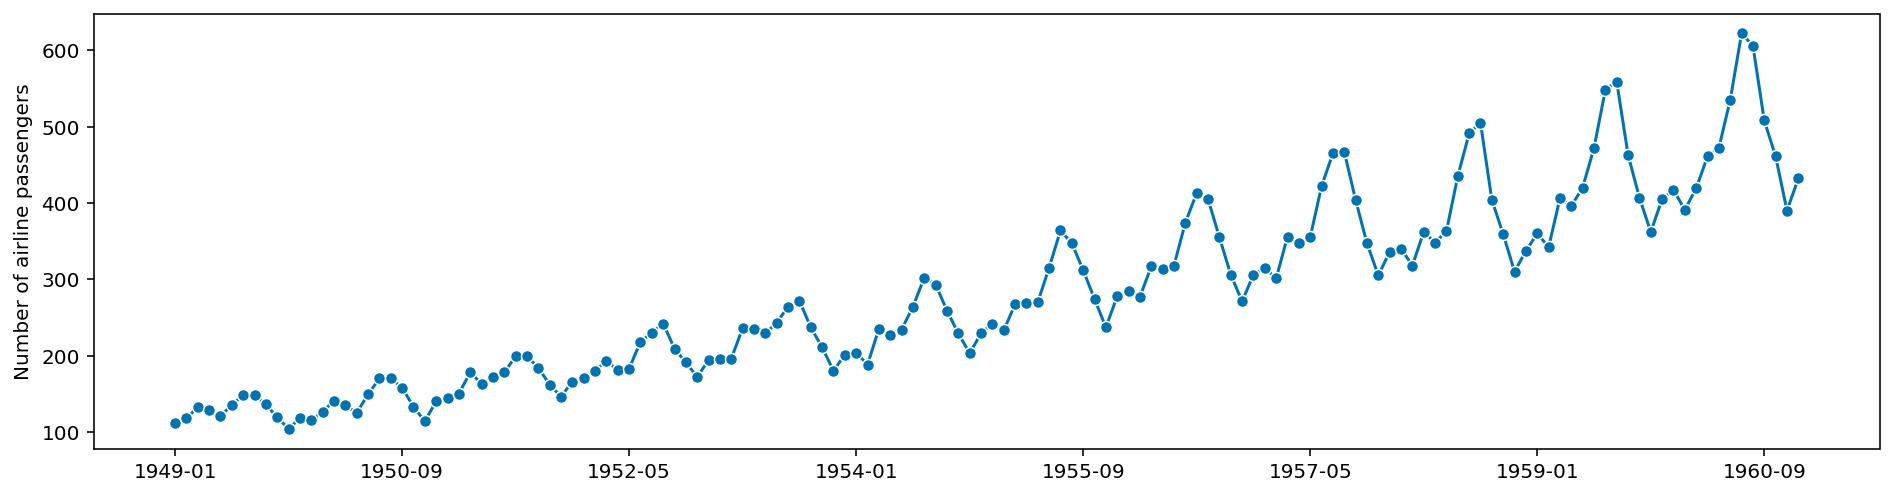

In [3]:
# загружаем временной ряд
y = load_airline()
# визуализируем временной ряд
plot_series(y);

Временной ряд состоит из последовательности пар: момент времени - значение (количество пассажиров международных авиарейсов).

Мы представили временной ряд как объект `Series`, в котором индекс представляет собой моменты времени. В этом примере у нас есть индекс  `PeriodIndex`.

In [4]:
# взглянем на индекс
y.index

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144)

## Разбиение набора на обучающую и тестовую выборки с учетом времени

108 36


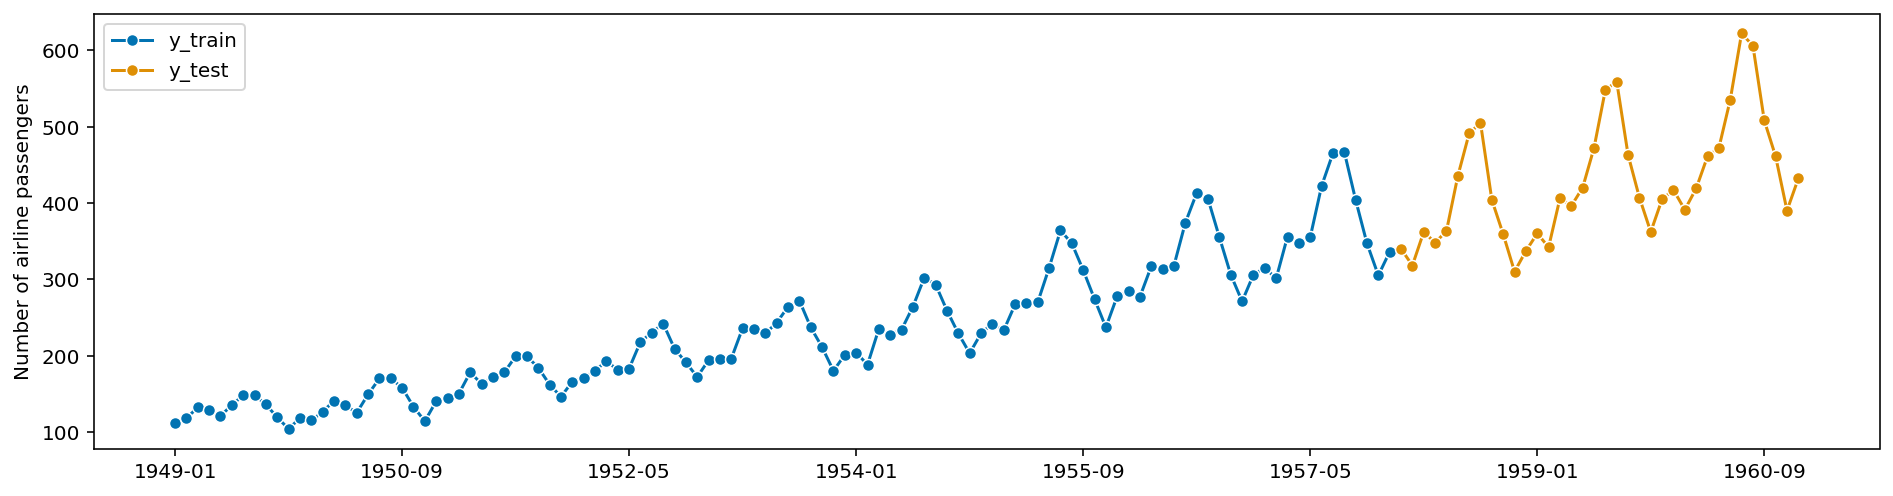

In [5]:
# импортируем функцию temporal_train_test_split(), которая разбивает набор
# на обучающую и тестовую выборки с учетом временной структуры
from sktime.forecasting.model_selection import temporal_train_test_split

# разбиваем выборку на обучающую и тестовую с учетом временной структуры,
# в тест попадают последние 36 точек (последние 3 года)
y_train, y_test = temporal_train_test_split(y, test_size=36)
# визуализируем результаты разбиения
plot_series(y_train, y_test, labels=['y_train', 'y_test'])
print(y_train.shape[0], y_test.shape[0])

## Этапы построения прогнозной модели в sktime
## Создание горизонта модели

Когда мы хотим сгенерировать прогнозы, нам нужно указать горизонт прогнозирования и передать его в наш алгоритм прогнозирования.
Для этого существует два основных способа.
- Первый способ – создание горизонта с помощью массива NumPy, состоящего из целочисленных значений. Этот способ предполагает наличие у временного ряда либо целочисленного индекса, либо периодического индекса (`PeriodIndex`). Целое число указывает количество временных точек или периодов в будущем, для которых мы хотим получить прогноз. Например, 1 означает прогноз на следующий период, 2 – на второй следующий период и так далее.


- Второй способ – создание горизонта с помощью объекта `ForecastingHorizon`. Его можно использовать для определения горизонтов прогнозирования, задав любой поддерживаемый тип индекса в качестве аргумента. Периодический индекс не предполагается.

Горизонты прогнозирования могут быть **абсолютными** или **относительными**. 
- **Абсолютный горизонт** привязан к конкретным временным точкам (временным меткам) в будущем. 
- **Относительный горизонт** привязан к разнице во времени по отношению к текущему моменту. По умолчанию текущим моментом является последняя временная точка обучающей выборки, переданной прогнозной модели.

Горизонты прогнозирования на основе массивов NumPy всегда относительны.

Объекты `ForecastingHorizon` могут быть как относительными, так и абсолютными. В частности, абсолютные горизонты прогнозирования можно указать только с помощью `ForecastingHorizon`.

In [6]:
# задаем относительный горизонт прогнозирования
fh = np.arange(1, 37)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

В данном случае мы генерируем ежемесячные прогнозы на следующие три года, поскольку исходный период ряда составляет 1 месяц. 
В другом примере, чтобы предсказать только второй и пятый месяц в будущем, можно написать:

In [7]:
# задаем относительный горизонт прогнозирования
fh = np.array([2, 5])
fh

array([2, 5])

In [8]:
# импортируем класс ForecastingHorizon, задающий горизонт
from sktime.forecasting.base import ForecastingHorizon

Объект `ForecastingHorizon` принимает в качестве входных данных абсолютные индексы, но считает входные данные абсолютными или относительными в зависимости от флага `is_relative` (по умолчанию задано значение `False`, т.е. предполагается абсолютный горизонт). Если мы передаем разности во времени по отношению к текущему моменту, то `ForecastingHorizon` автоматически задает относительный горизонт. Если же мы передаем индексы объекта pandas, то `ForecastingHorizon` автоматически задает абсолютный горизонт.

In [9]:
# задаем абсолютный горизонт прогнозирования, передаем индексы
# объекта pandas, по умолчанию у нас ожидается абсолютный горизонт
# (is_relative=False)
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

Здесь мы уже видим абсолютные индексы – конкретные метки времени.
Абсолютный горизонт, созданный с помощью класса `ForecastingHorizon`, можно преобразовать в относительный и наоборот с помощью методов `.to_relative()` и `.to_absolute()`. Оба эти преобразования требуют передачи `cutoff` в соответствующий метод. `Сutoff` – это последняя временная точка обучающей выборки, отсечка, разделяющая обучающую и тестовую выборки.

In [10]:
# задаем порог отсечения
cutoff = pd.Period('1957-12', freq='M')

In [11]:
# превращаем наш абсолютный горизонт в относительный
fh = fh.to_relative(cutoff)
fh

ForecastingHorizon([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36],
           dtype='int64', is_relative=True)

In [12]:
# превращаем наш относительный горизонт в абсолютный
fh = fh.to_absolute(cutoff)
fh

ForecastingHorizon(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', is_relative=False)

Давайте зададим горизонт, создадим модель, обучим ее, получим прогнозы, визуализируем их, оценим их качество. Начнем с двух наивных стратегий прогнозирования, которые могут служить ориентирами для сравнения с более сложными подходами.

## Построение первых прогнозных моделей

In [13]:
# импортируем функцию и класс, вычисляющие метрику качества sMAPE
from sktime.performance_metrics.forecasting import (
    mean_absolute_percentage_error,
    MeanAbsolutePercentageError)
# импортируем класс NaiveForecaster, в котором реализованы модели
# наивного прогноза и наивного сезонного прогноза
from sktime.forecasting.naive import NaiveForecaster

### Модель наивного прогноза

0.2825727513227514

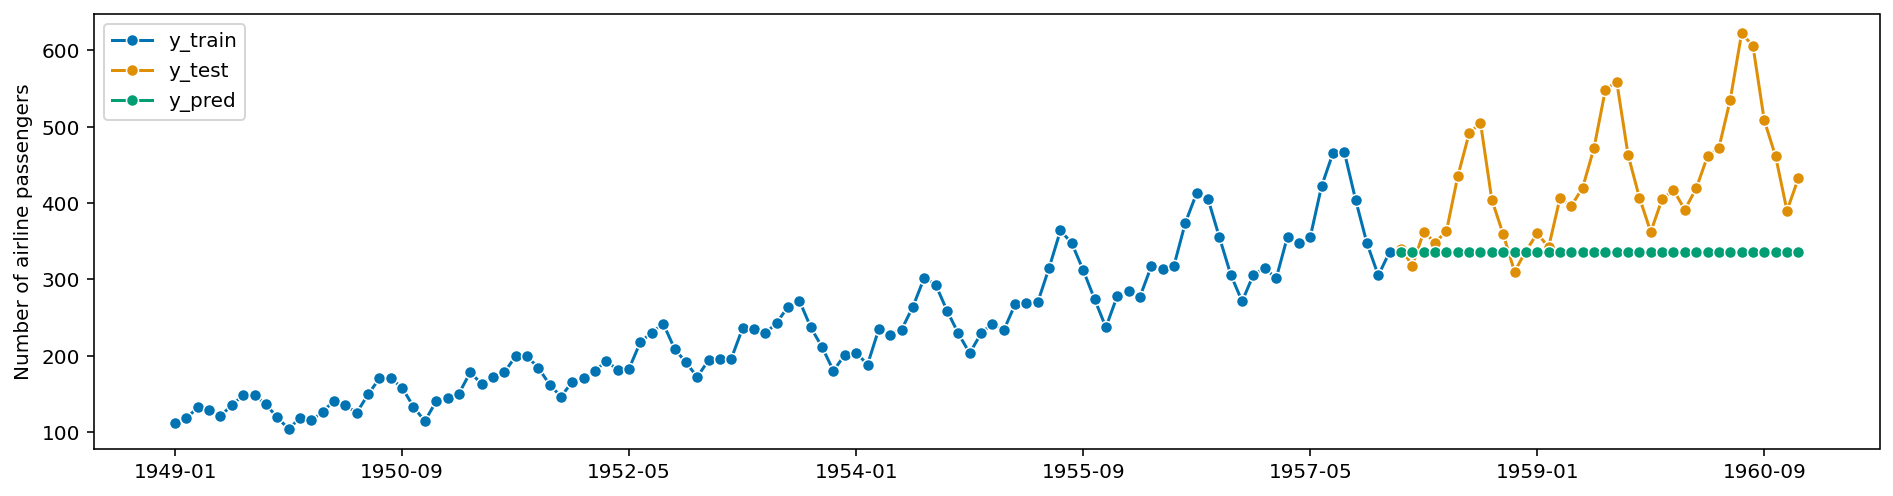

In [14]:
# задаем абсолютный горизонт прогнозирования
fh = ForecastingHorizon(y_test.index, is_relative=False)
# создаем экземпляр класса NaiveForecaster - 
# модель наивного прогноза
forecaster = NaiveForecaster(strategy='last')
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы, передав в модель абсолютный горизонт прогнозирования
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE с помощью функции mean_absolute_percentage_error()
mean_absolute_percentage_error(y_pred, y_test)

### Модель наивного сезонного прогноза

0.1625132136966463

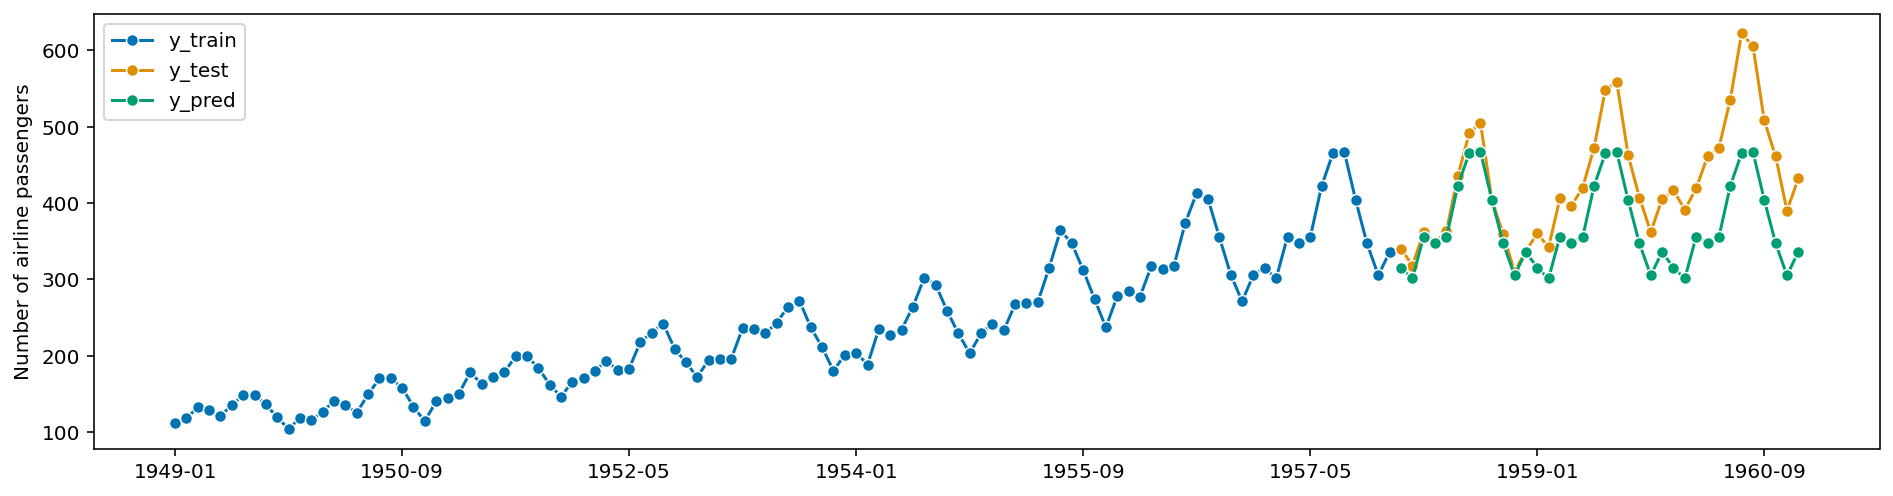

In [15]:
# создаем экземпляр класса NaiveForecaster, в котором
# реализована модель, которая прогнозирует последнее 
# известное значение данного сезона, 
# sp=12 - сезонный период 12 месяцев
forecaster = NaiveForecaster(strategy='last', sp=12)
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE с помощью класса MeanAbsolutePercentageError
mape = MeanAbsolutePercentageError()
mape(y_pred, y_test)

Здесь мы видим, что каждый раз мы передавали горизонт прогнозирования в метод `.predict()`. Некоторым прогнозным моделям требуется, чтобы горизонт был передан уже в метод `.fit()`, а не в метод `.predict()`. Такие модели выдадут ошибку, если горизонт не передан в метод `.fit()`. Все прогнозные модели помнят горизонт, уже переданный им в методе `.fit()`, когда генерируют прогнозы.

0.1625132136966463

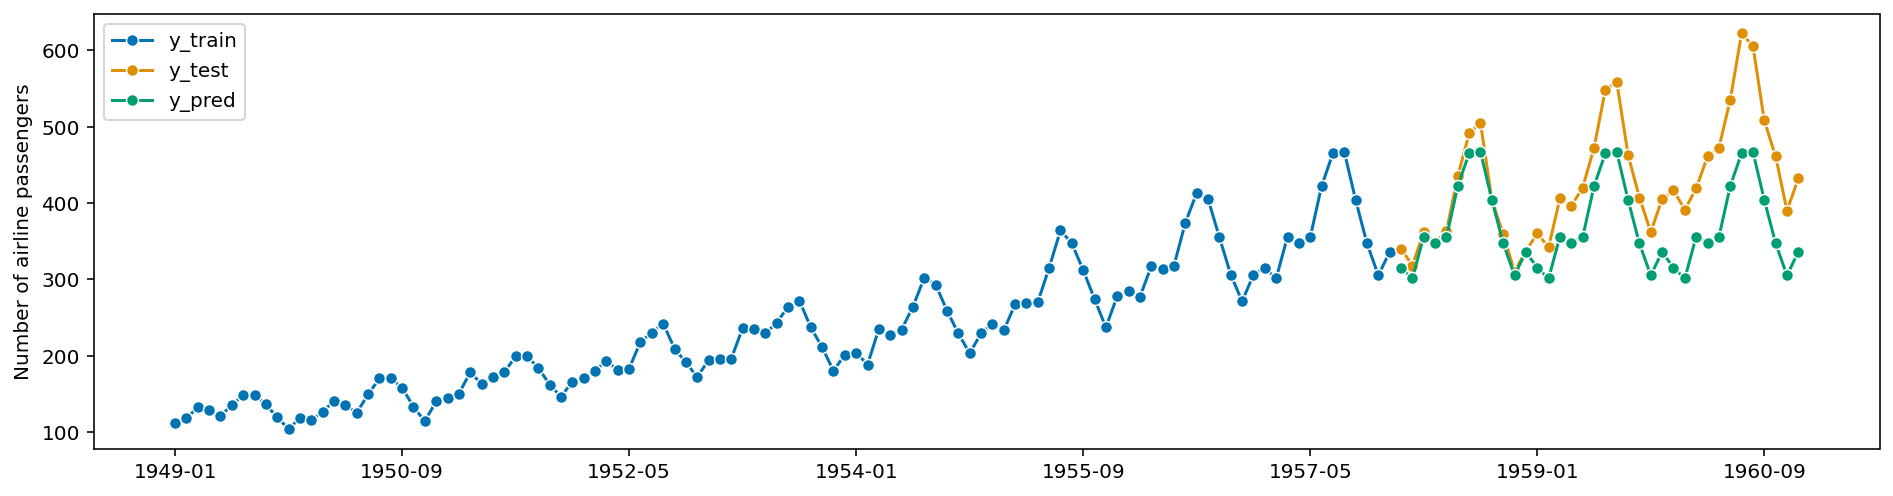

In [16]:
# задаем относительный горизонт прогнозирования
fh = np.arange(1, 37)
# обучаем модель
forecaster.fit(y_train, fh=fh)
# получаем прогнозы
y_pred = forecaster.predict()
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

## Работа с экзогенными временными рядами

Многие прогнозные модели могут работать с экзогенными временными рядами, то есть другими временными рядами, которые не прогнозируются, но полезны для прогнозирования `y`. Экзогенные временные ряды всегда передаются в качестве аргумента X в методы `.fit()`, `.predict()` и др. Экзогенные временные ряды всегда следует передавать в виде объектов `DataFrame` библиотеки pandas. 
Большинство прогнозных моделей, которые могут работать с экзогенными временными рядами, исходят из того, что:
- временные индексы `X`, переданные в метод `.fit()`, являются надмножеством временных индексов `y`, переданных  в метод `.fit()`;
- временные индексы `X`, переданные в метод `.predict()`, являются надмножеством временных индексов, находящихся в `fh`.

Общая схема построения модели при наличии экзогенных данных показана ниже.

In [17]:
# загружаем временной ряд
y = load_airline()

# создаем какие-то глупые экзогенные данные
X = pd.DataFrame(index=y.index)

# задаем относительный горизонт прогнозирования
fh = np.arange(1, 37)

# создаем экземпляр класса NaiveForecaster
forecaster = NaiveForecaster(strategy='last', sp=12)

# обучаем модель
forecaster.fit(y, X=X, fh=fh)

# получаем прогнозы
y_pred = forecaster.predict(X=X)

## Скользящие обновления модели и прогнозов (скользящее развертывание модели)

### Обновление модели с помощью метода .update()

Обычный сценарий использования  модели требует, чтобы прогнозная модель регулярно обновлялась по мере поступления новых данных и делала прогнозы на постоянной основе. Это особенно полезно, если такой прогноз необходимо делать в определенные моменты времени, например, ежедневно или еженедельно. Прогнозные модели библиотеки sktime поддерживают такой сценарий с помощью методов `.update()` и `update_predict()`.
Метод `.update()` можно вызвать, когда прогнозная модель уже обучена, чтобы принять новые данные и получить обновленные прогнозы, это называется «шагом обновления» (update step).
После обновления внутреннее состояние модели «текущий момент» (отсечка или `cutoff`) приравнивается к последней метке времени, наблюдаемой в батче новых данных (предполагается, что она относится к более позднему моменту времени, чем ранее просмотренные данные).

Общая схема выглядит следующим образом:
1. Задаем прогнозную модель.
2. Задаем относительный горизонт прогнозирования.
3. Обучаем прогнозную модель на исходном батче данных с помощью метода `.fit()`.
4. Делаем прогнозы в соответствии с относительным горизонтом прогнозирования, используя метод `.predict()`.
5. Получаем новые данные и используем метод `.update()`  для приема новых данных.
6. Делаем прогнозы с помощью метода `predict()` по обновленным данным.
7. Повторяем 5 и 6 столько раз, сколько потребуется.

Предположим, что в примере с авиапассажирами мы хотим делать прогнозы на год вперед, но каждый месяц, начиная с декабря 1957 года.

In [18]:
# обратите внимание, что в сценарии у нас будет информация только 
# о части этого набора в определенные моменты времени
y = load_airline()

In [19]:
# декабрь 1957

# это данные, накопленные к декабрю 1957
y_1957Dec = y[:-36]
y_1957Dec

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1957-08    467.0
1957-09    404.0
1957-10    347.0
1957-11    305.0
1957-12    336.0
Freq: M, Name: Number of airline passengers, Length: 108, dtype: float64

In [20]:
# импортируем класс AutoETS, в котором реализована модель
# тройного экспоненциального сглаживания
from sktime.forecasting.ets import AutoETS

In [21]:
# шаг 1: задаем прогнозную модель
forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)

In [22]:
# шаг 2: задаем относительный горизонт прогнозирования: 
# на один год вперед, все месяцы
fh = np.arange(1, 13)
fh 

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [23]:
# шаг 3: первый раз обучаем модель на данных 
# с января 1949 по декабрь 1957 включительно
forecaster.fit(y_1957Dec)

# шаг 4: получаем 12 прогнозов с января по декабрь 1958 включительно
y_pred_1957Dec = forecaster.predict(fh)
y_pred_1957Dec

1958-01    344.324222
1958-02    344.628383
1958-03    396.374063
1958-04    381.874141
1958-05    378.945559
1958-06    429.682390
1958-07    474.579183
1958-08    471.024312
1958-09    417.887756
1958-10    363.910209
1958-11    317.750863
1958-12    360.754712
Freq: M, dtype: float64

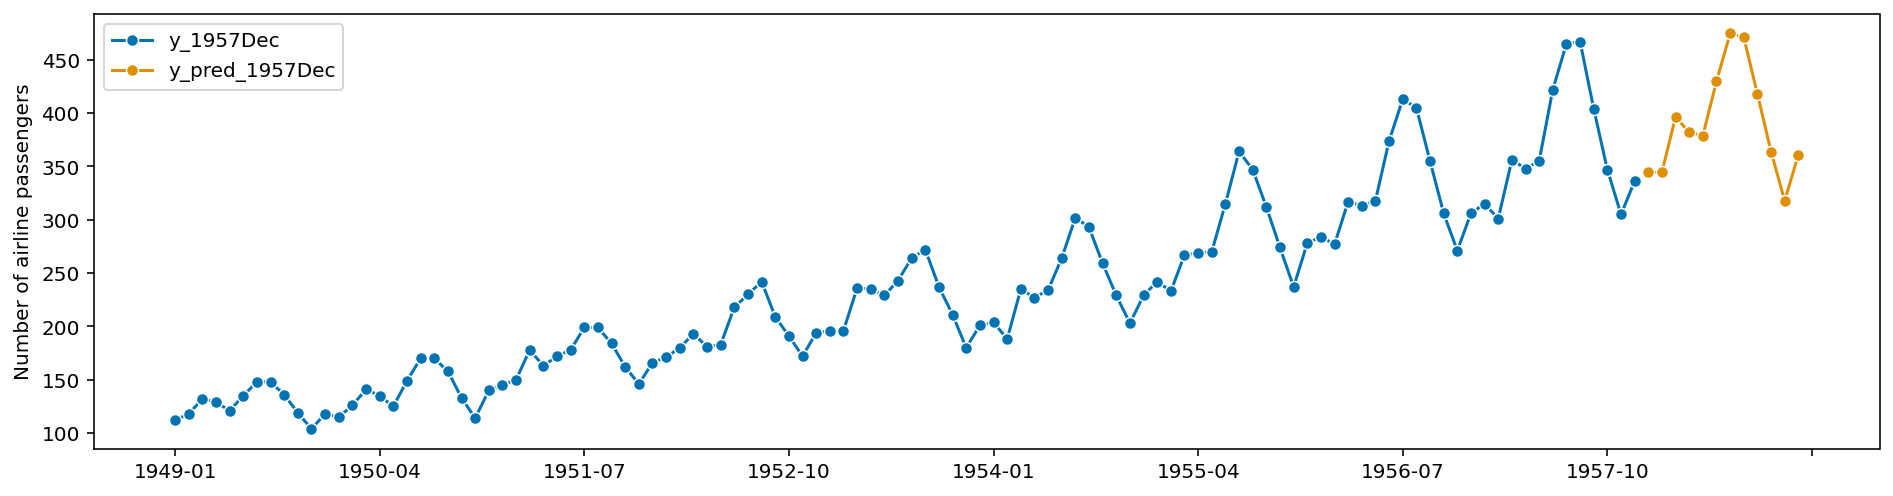

In [24]:
# визуализируем исторические данные и прогнозы
plot_series(y_1957Dec, y_pred_1957Dec, 
            labels=['y_1957Dec', 'y_pred_1957Dec']);

In [25]:
# январь 1958

# смотрим новые данные:
y_1958Jan = y[[-36]]
y_1958Jan

Period
1958-01    340.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [26]:
# шаг 5: мы обновляем прогнозную модель с учетом новых данных
forecaster.update(y_1958Jan)

# шаг 6: получаем прогнозы с помощью обновленной модели
y_pred_1958Jan = forecaster.predict(fh)
# обратите внимание, что fh является относительным, поэтому прогнозы 
# автоматически сдвигаются на 1 месяц вперед, т.е. теперь охватывают
# период с февраля 1958 по январь 1959 включительно
y_pred_1958Jan

1958-02    341.518092
1958-03    392.852642
1958-04    378.524976
1958-05    375.665178
1958-06    426.013948
1958-07    470.580314
1958-08    467.113014
1958-09    414.462982
1958-10    360.966402
1958-11    315.211953
1958-12    357.906992
1959-01    363.041653
Freq: M, dtype: float64

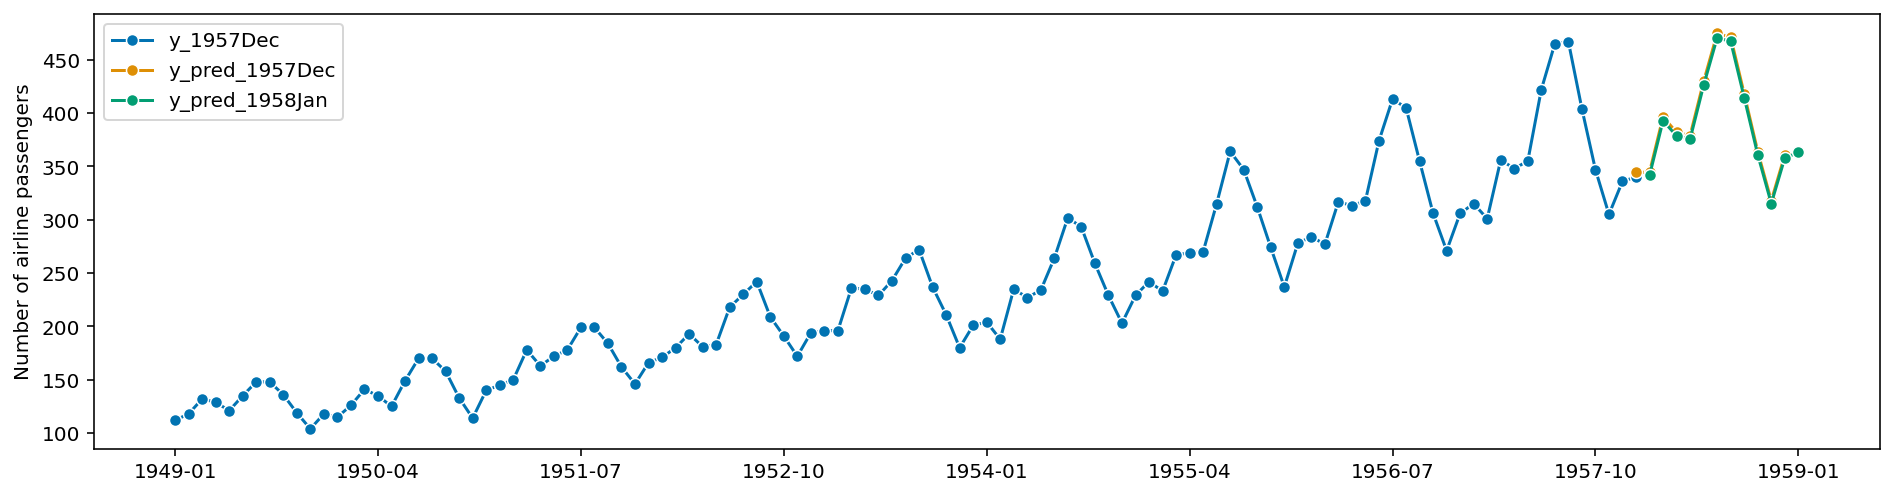

In [27]:
# визуализируем исторические данные и прогнозы
plot_series(y[:-35], y_pred_1957Dec, y_pred_1958Jan,
            labels=['y_1957Dec', 'y_pred_1957Dec', 'y_pred_1958Jan']);

In [28]:
# февраль 1958

# смотрим новые данные:
y_1958Feb = y[[-35]]
y_1958Feb

Period
1958-02    318.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [29]:
# шаг 5: мы обновляем прогнозную модель с учетом новых данных
forecaster.update(y_1958Feb)

# шаг 6: получаем прогнозы с помощью обновленной модели
y_pred_1958Feb = forecaster.predict(fh)
y_pred_1958Feb

1958-03    371.673729
1958-04    357.224822
1958-05    353.636919
1958-06    400.104428
1958-07    440.901688
1958-08    436.677563
1958-09    386.599339
1958-10    335.851820
1958-11    292.498702
1958-12    331.299363
1959-01    335.025863
1959-02    332.440702
Freq: M, dtype: float64

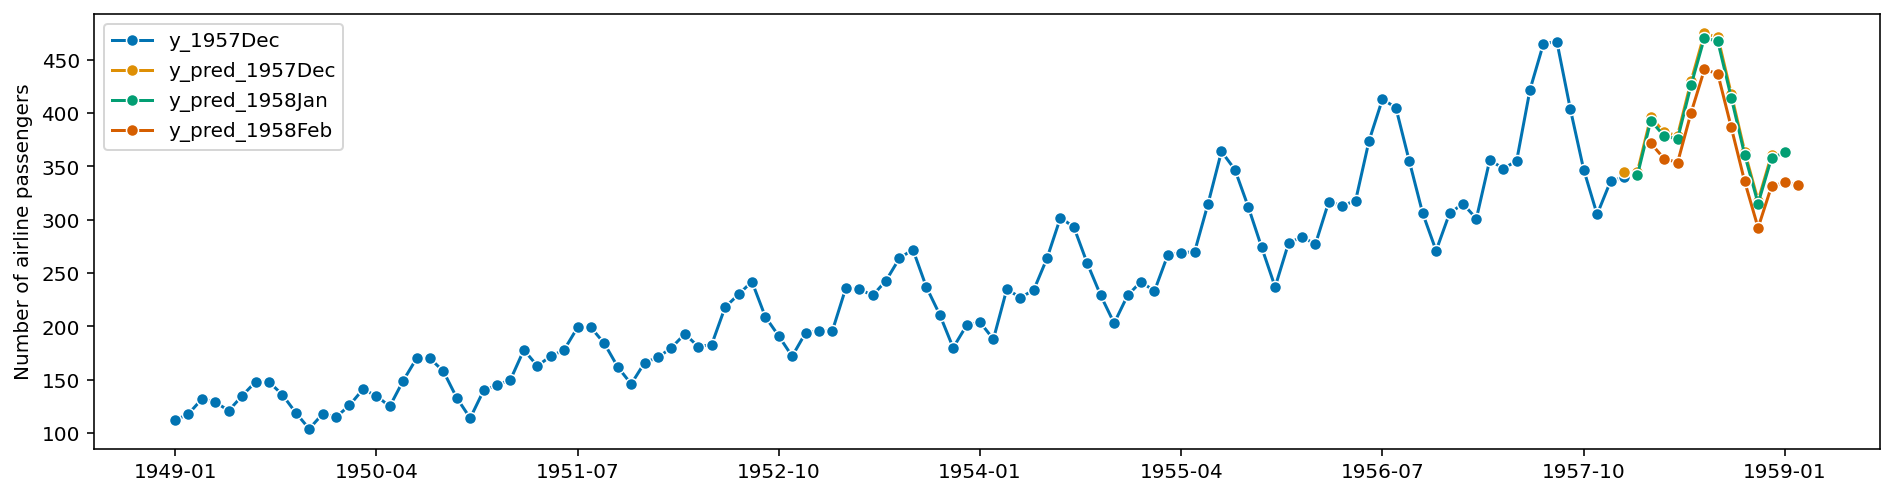

In [30]:
# визуализируем исторические данные и прогнозы
plot_series(y[:-35], y_pred_1957Dec, y_pred_1958Jan, y_pred_1958Feb,
            labels=['y_1957Dec', 'y_pred_1957Dec', 
                    'y_pred_1958Jan', 'y_pred_1958Feb']);

и так далее...

In [31]:
# март 1958

# смотрим новые данные:
y_1958Mar = y[[-34]]
y_1958Mar

Period
1958-03    362.0
Freq: M, Name: Number of airline passengers, dtype: float64

In [32]:
# шаги 5-6: обновляем/прогнозируем за один шаг
forecaster.update_predict_single(y_1958Mar, fh=fh)

1958-04    349.161733
1958-05    346.920333
1958-06    394.054912
1958-07    435.845496
1958-08    433.322360
1958-09    384.849639
1958-10    335.540594
1958-11    293.177215
1958-12    333.278828
1959-01    338.596459
1959-02    336.983414
1959-03    388.122274
Freq: M, dtype: float64

### Обновление модели без вычисления параметров заново

In [33]:
# апрель 1958

# смотрим новые данные:
y_1958Apr = y[[-33]]

# шаг 5: выполняем обновление, не вычисляя параметров модели заново
forecaster.update(y_1958Apr, update_params=False);

## Вероятностное прогнозирование: прогнозные интервалы, квантили, дисперсия, прогнозы на основе распределения

sktime предлагает унифицированный интерфейс для получения вероятностных прогнозов. Для вероятностных прогнозов доступны следующие методы:
- `.predict_interval()` генерирует интервальные прогнозы. Нужно задать параметр `coverage` (ширину покрытия). Метод генерирует симметричные прогнозные интервалы, например, `coverage=0.9` вернет нижнюю границу прогноза в квантиле 0.5 - coverage/2 = 0.05 и верхнюю границу прогноза в квантиле 0.5 + coverage/2 = 0.95.
- `.predict_quantiles()` генерирует квантильные прогнозы. Нужно задать параметр `alpha` (значения квантилей).
- `.predict_var()` вычисляет дисперсию прогнозов.
- `.predict_proba()` генерирует прогнозы на основе распределения.
Не все модели способны выдавать вероятностный прогноз, но если модель предлагает один вид вероятностного прогноза, она также способна выдавать другие. Список моделей с такой возможностью можно запросить с помощью функции `all_estimators()`, выполнив поиск моделей, у которых тег `feature:pred_int` имеет значение `True`.

In [34]:
# импортируем класс ThetaForecaster
from sktime.forecasting.theta import ThetaForecaster
# задаем горизонт
fh = np.arange(1, 13)
# обучаем модель
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=fh)

ThetaForecaster(sp=12)

In [35]:
# получаем интервальные прогнозы
coverage = 0.9
y_pred_ints = forecaster.predict_interval(coverage=coverage)
y_pred_ints

Coverage            
                0.9            
              lower       upper
1961-01  418.280121  464.281951
1961-02  402.215881  456.888055
1961-03  459.966113  522.110500
1961-04  442.589309  511.399214
1961-05  443.525027  518.409480
1961-06  506.585814  587.087737
1961-07  561.496768  647.248956
1961-08  557.363322  648.062363
1961-09  477.658056  573.047752
1961-10  407.915090  507.775355
1961-11  346.942924  451.082016
1961-12  394.708221  502.957142

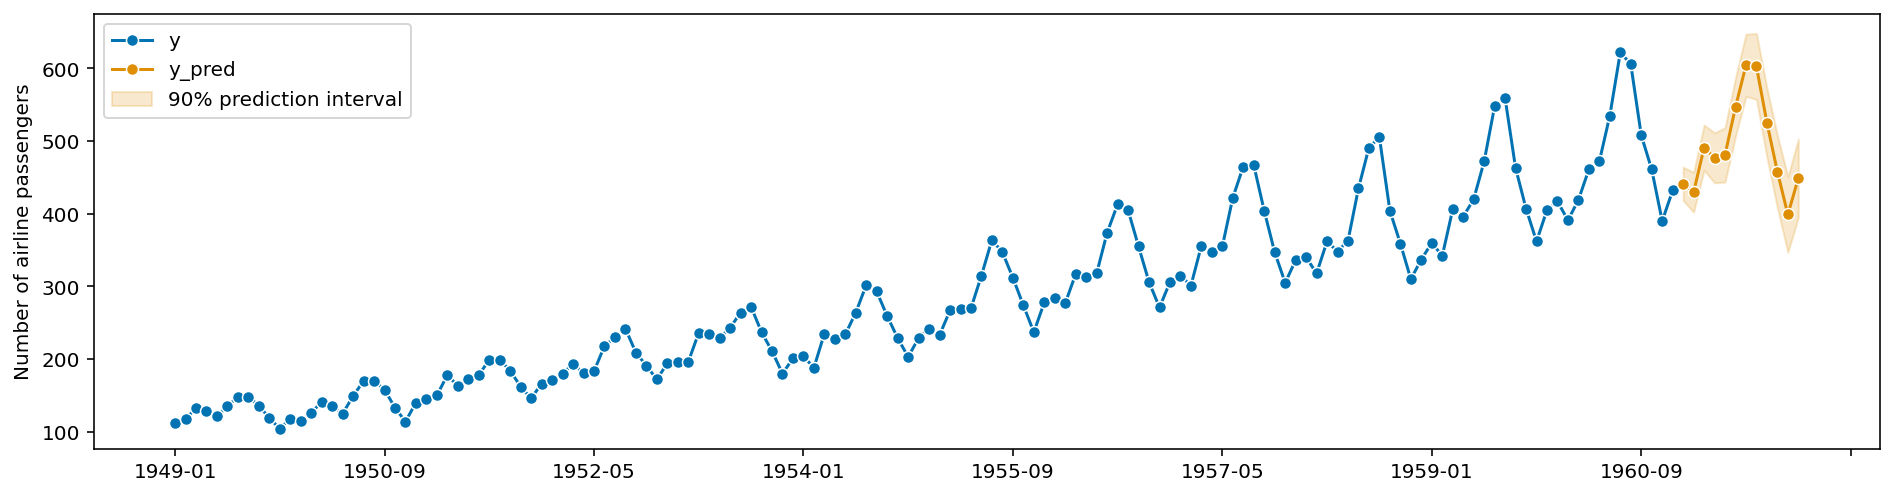

In [36]:
# получаем прогнозы
y_pred = forecaster.predict()

# визуализируем интервальные прогнозы
fig, ax = plot_series(
    y, y_pred, labels=['y', 'y_pred'], pred_interval=y_pred_ints
)

In [37]:
# получаем квантильные прогнозы
y_pred_quantiles = forecaster.predict_quantiles(alpha=[0.275, 0.975])
y_pred_quantiles

Quantiles            
              0.275       0.975
1961-01  432.922219  468.688317
1961-02  419.617696  462.124925
1961-03  479.746287  528.063109
1961-04  464.491077  517.990291
1961-05  467.360286  525.582418
1961-06  532.209079  594.798754
1961-07  588.791160  655.462879
1961-08  586.232267  656.750129
1961-09  508.020007  582.184821
1961-10  439.699996  517.340645
1961-11  380.089754  461.057161
1961-12  429.163184  513.325954

In [38]:
# оцениваем дисперсию прогнозов
y_pred_var = forecaster.predict_var()
y_pred_var

,0
1961-01,195.540049
1961-02,276.196509
1961-03,356.852968
1961-04,437.509428
1961-05,518.165887
1961-06,598.822347
1961-07,679.478807
1961-08,760.135266
1961-09,840.791726
1961-10,921.448185


In [39]:
# получаем полные вероятностные прогнозы
y_pred_proba = forecaster.predict_proba()
y_pred_proba

<tfp.distributions.Normal 'Normal' batch_shape=[12, 1] event_shape=[] dtype=float32>

## Перекрестная проверка расширяющимся или скользящим окном

Библиотека sktime позволяет провести бэктестинг (оценку качества модели) с помощью перекрестной проверки расширяющим окном или скользящим окном. Для этого нам понадобиться функция `evalute()`, которая принимает в качестве аргументов:
- прогнозную модель;
- тип перекрестной проверки, например, `ExpandingWindowSplitter` или `SlidingWindowSplitter`;
- стратегию обучения: по умолчанию прогнозная модель всегда обучается заново (`'refit'`).

In [40]:
# импортируем прогнозную модель
from sktime.forecasting.arima import AutoARIMA
# импортируем классы, в которых реализованы стратегии перекрестной проверки
from sktime.forecasting.model_selection import (ExpandingWindowSplitter, 
                                                SlidingWindowSplitter)
# импортируем функцию evalute() для оценивания
# качества модели в ходе перекрестной проверки
from sktime.forecasting.model_evaluation import evaluate

Начнем с перекрестной проверки расширяющимся окном. В перекрестной проверке расширяющимся окном (expanding window) количество наблюдений, использованных для обучения в каждой итерации, растет с числом итераций, предоставляя все больший объем данных для обучения. Перекрестная проверка расширяющимся окном осуществляется с помощью класса `ExpandingWindowSplitter`. Ключевыми параметрами класса `ExpandingWindowSplitter` являются:
- `window_length` – длина окна (обучающей выборки);
- `fh` – длина горизонта прогнозирования;
- `step_length` – длина шага между окнами;
- `initial_window` – длина первого окна (первой обучающей выборки).

In [41]:
# задаем прогнозную модель
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

# задаем перекрестную проверку расширяющимся окном
cv = ExpandingWindowSplitter(step_length=12, 
                             fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                             initial_window=72)

# результаты проверки записываем в датафрейм
df = evaluate(forecaster=forecaster, y=y, cv=cv, 
              strategy='refit', return_data=True)
df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.061710,7.613691,0.014284,72,1954-12
1,0.050042,16.246612,0.016951,84,1955-12
2,0.029802,13.539827,0.013978,96,1956-12
3,0.053773,6.011462,0.013034,108,1957-12
4,0.073820,8.648611,0.016864,120,1958-12
5,0.030976,18.679379,0.015308,132,1959-12


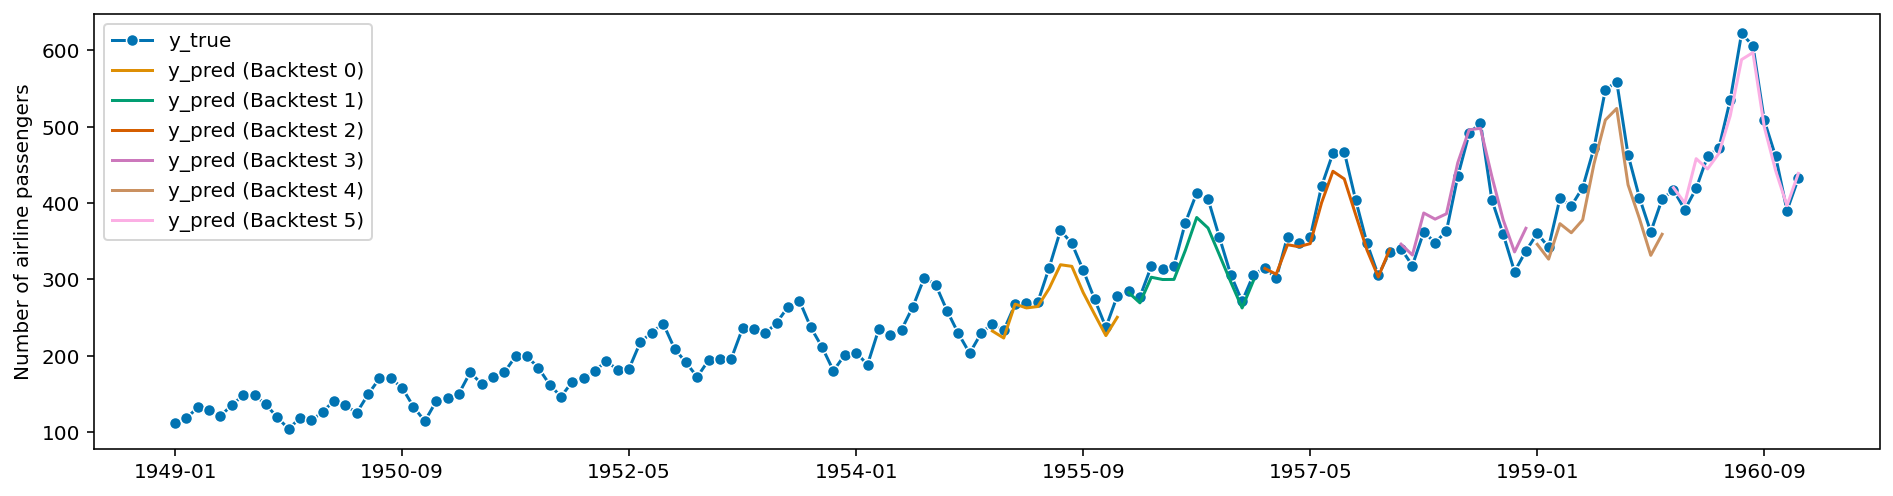

In [42]:
# визуализируем процесс оценки прогнозной модели
fig, ax = plot_series(
    y,
    df['y_pred'].iloc[0],
    df['y_pred'].iloc[1],
    df['y_pred'].iloc[2],
    df['y_pred'].iloc[3],
    df['y_pred'].iloc[4],
    df['y_pred'].iloc[5],
    markers=['o', '', '', '', '', '', ''],
    labels=['y_true'] + ['y_pred (Backtest ' + str(x) + ')' for x in range(6)],
)
ax.legend();

В перекрестной проверке скользящим окном (sliding window) в каждой новой итерации мы будем обучаться на более свежих данных, обучающая выборка каждый раз сдвигается вперед по временной оси. Перекрестная проверка скользящим окном осуществляется с помощью класса `SlidingWindowSplitter`. Ключевыми параметрами класса `SlidingWindowSplitter` являются:
- `window_length` – длина окна (обучающей выборки);
- `fh` – длина горизонта прогнозирования;
- `step_length` – длина шага между окнами;
- `initial_window` – длина первого окна (первой обучающей выборки).

In [43]:
# задаем прогнозную модель
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

# задаем перекрестную проверку скользящим окном
cv = SlidingWindowSplitter(step_length=12, 
                           fh=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                           window_length=36)

# результаты проверки записываем в датафрейм
df = evaluate(forecaster=forecaster, y=y, cv=cv, 
              strategy='refit', return_data=True)
df.iloc[:, :5]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.036172,13.260824,0.014358,36,1951-12
1,0.048679,6.868300,0.015338,36,1952-12
2,0.057325,6.318019,0.015584,36,1953-12
3,0.075316,2.552427,0.020090,36,1954-12
4,0.025864,2.396307,0.014123,36,1955-12
5,0.023879,3.014750,0.016760,36,1956-12
6,0.074643,7.925591,0.015907,36,1957-12
7,0.108192,2.278108,0.012129,36,1958-12
8,0.047784,2.140259,0.012502,36,1959-12


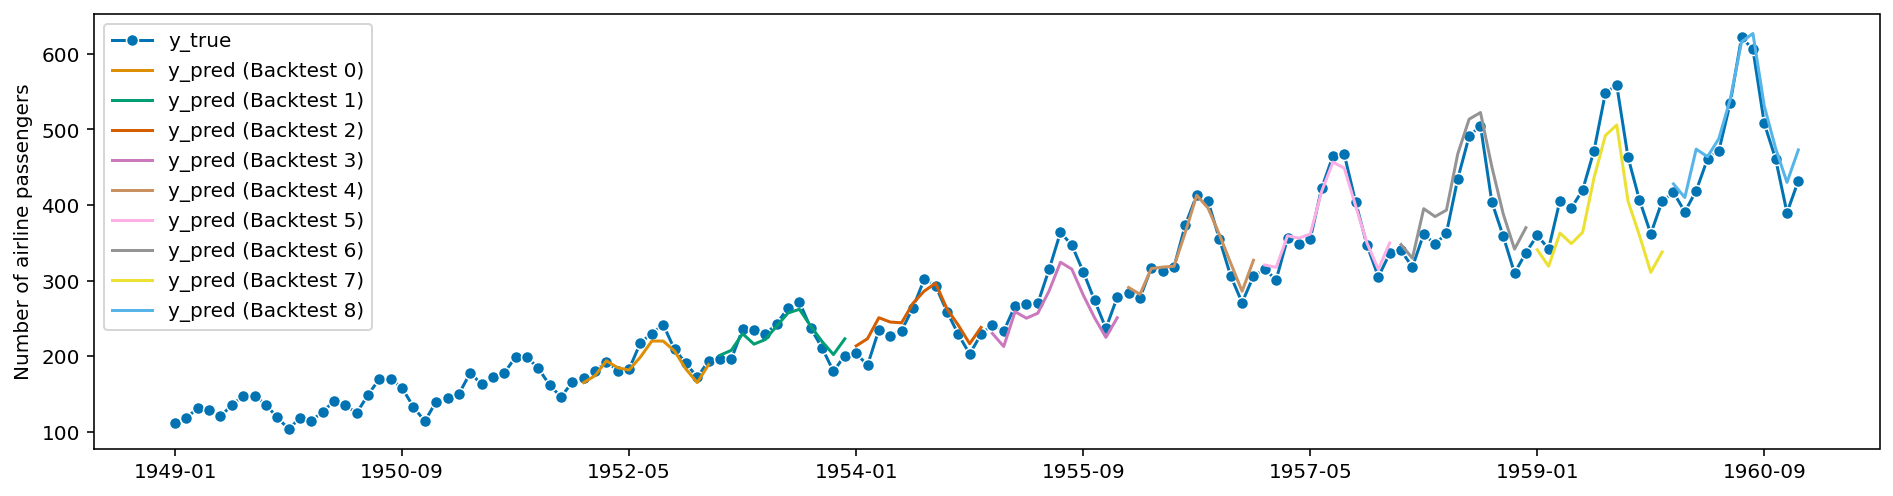

In [44]:
# визуализируем процесс оценки прогнозной модели
fig, ax = plot_series(
    y,
    df['y_pred'].iloc[0],
    df['y_pred'].iloc[1],
    df['y_pred'].iloc[2],
    df['y_pred'].iloc[3],
    df['y_pred'].iloc[4],
    df['y_pred'].iloc[5],
    df['y_pred'].iloc[6],
    df['y_pred'].iloc[7],
    df['y_pred'].iloc[8],
    markers=['o', '', '', '', '', '', '', '', '', ''],
    labels=['y_true'] + ['y_pred (Backtest ' + str(x) + ')' for x in range(9)],
)
ax.legend();

Библиотека sktime поддерживает ряд часто используемых прогнозистов, многие из которых связаны с современными пакетами по прогнозированию. Все прогнозные модели поддерживают единый интерфейс sktime.
Основные классы, которые в настоящее время стабильно поддерживаются:
- классы `ExponentialSmoothing`, `ThetaForecaster` и `autoETS` из пакета `statsmodels`;
- классы `ARIMA` и `autoARIMA` из пакета `pmdarima`;
- классы `BATS` и `TBATS` из пакета `tbats`;
- класс `PolynomialTrend` для прогнозирования полиномиальных трендов;
- класс `Prophet`, который позволяет использовать библиотеку `prophet` от Facebook в формате интерфейса sktime.
Начнем с класса `ExponentialSmoothing`, выполняющего экспоненциальное сглаживание. К нашему набору данных об авиапассажирах мы применим экспоненциальное сглаживание с аддитивным трендом и мультипликативной сезонностью. Обратите внимание, что, поскольку это месячные данные, хорошим выбором для сезонной периодичности (`sp`) является 12 (=предполагаемая периодичность для года).

### Класс ExponentialSmoothing

In [45]:
# импортируем класс ExponentialSmoothing, в котором 
# реализовано экспоненциальное сглаживание
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.05172724821807391

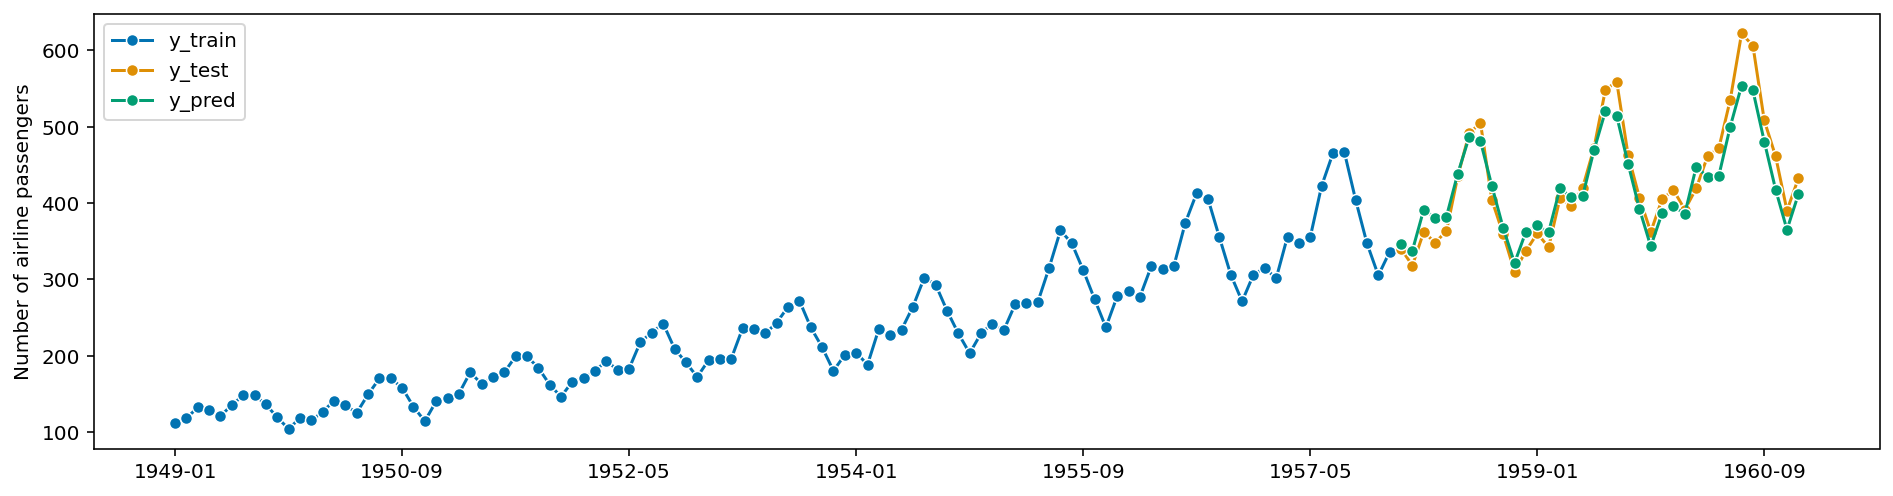

In [46]:
# создаем экземпляр класса ExponentialSmoothing, задаем
# аддитивный тренд, мультипликативную сезонность, sp=12
forecaster = ExponentialSmoothing(trend='add', seasonal='mul', sp=12)
# задаем абсолютный горизонт прогнозирования
fh = ForecastingHorizon(y_test.index, is_relative=False)
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Классы ARIMA, AutoARIMA и StatsForecastAutoARIMA

In [47]:
# импортируем классы ARIMA, AutoARIMA и StatsForecastAutoARIMA
from sktime.forecasting.arima import ARIMA, AutoARIMA 
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

0.04166639016608004

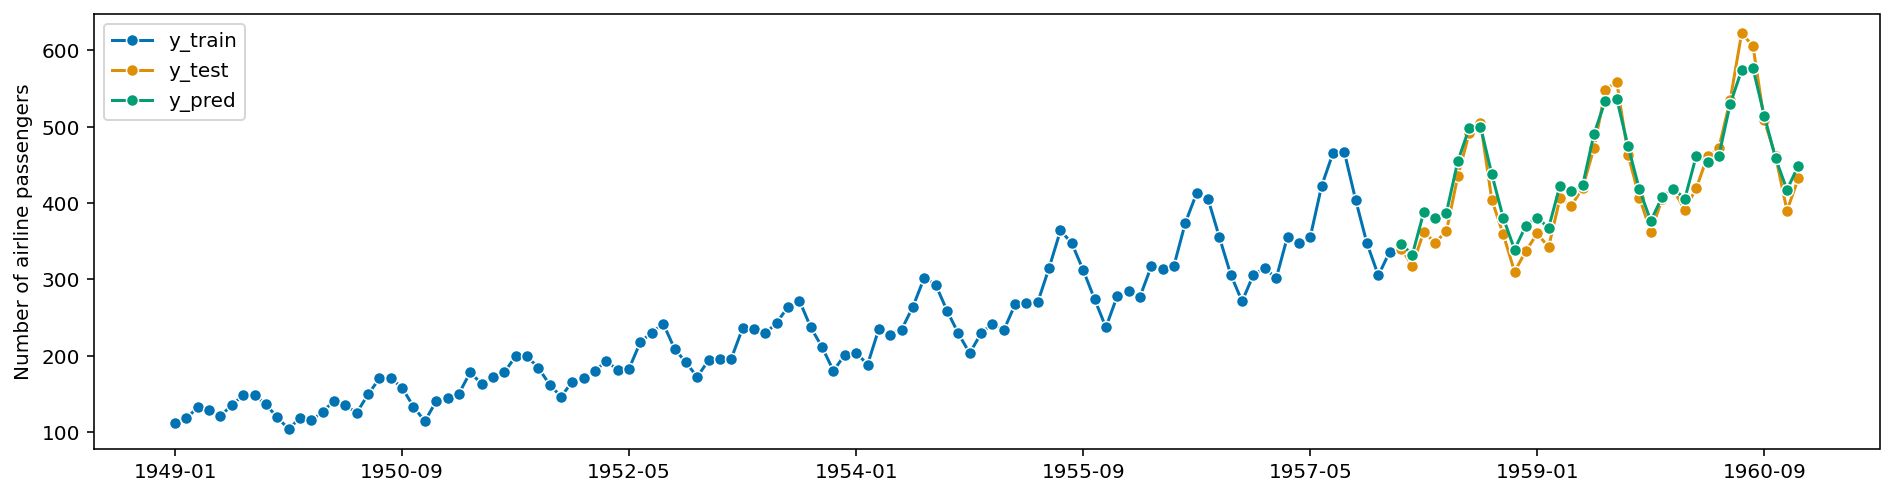

In [48]:
# создаем экземпляр класса ARIMA с нужными параметрами
forecaster = ARIMA(order=(1, 1, 0), 
                   seasonal_order=(0, 1, 0, 12), 
                   suppress_warnings=True)
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

0.04093675930591672

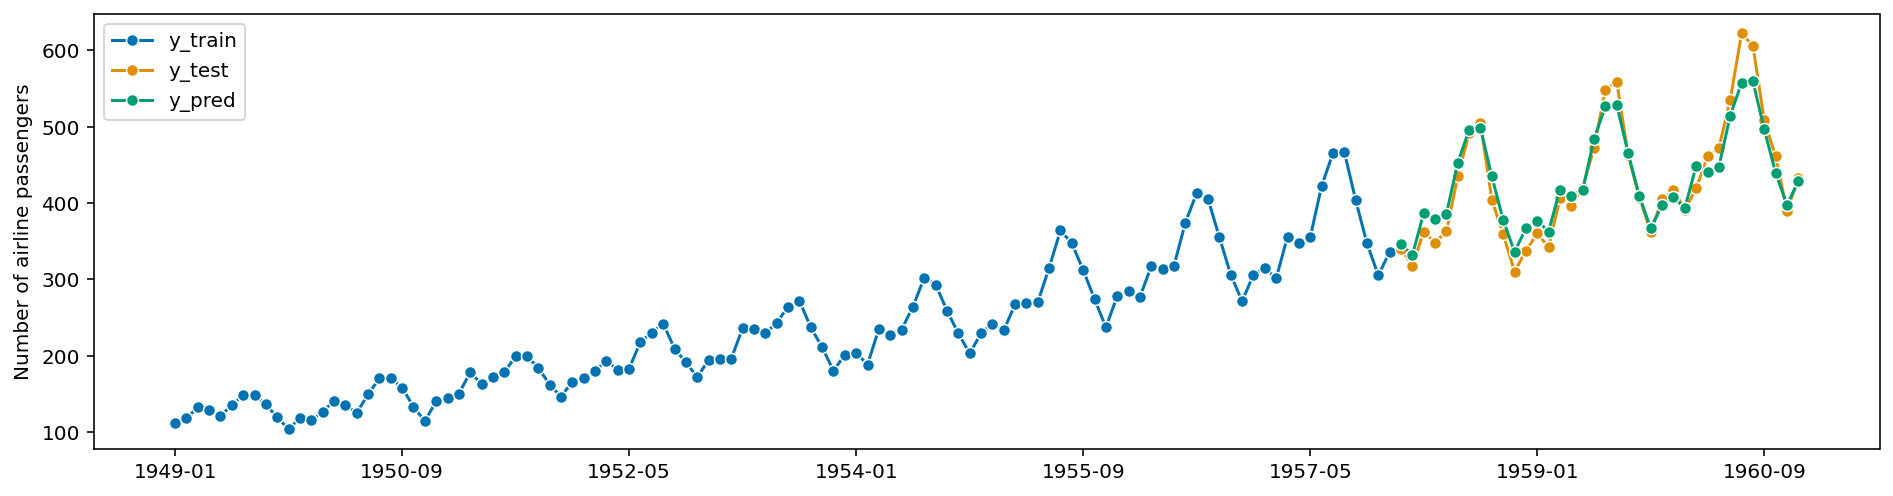

In [49]:
# создаем экземпляр класса AutoARIMA, в котором 
# реализована модель AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

0.04093539044441257

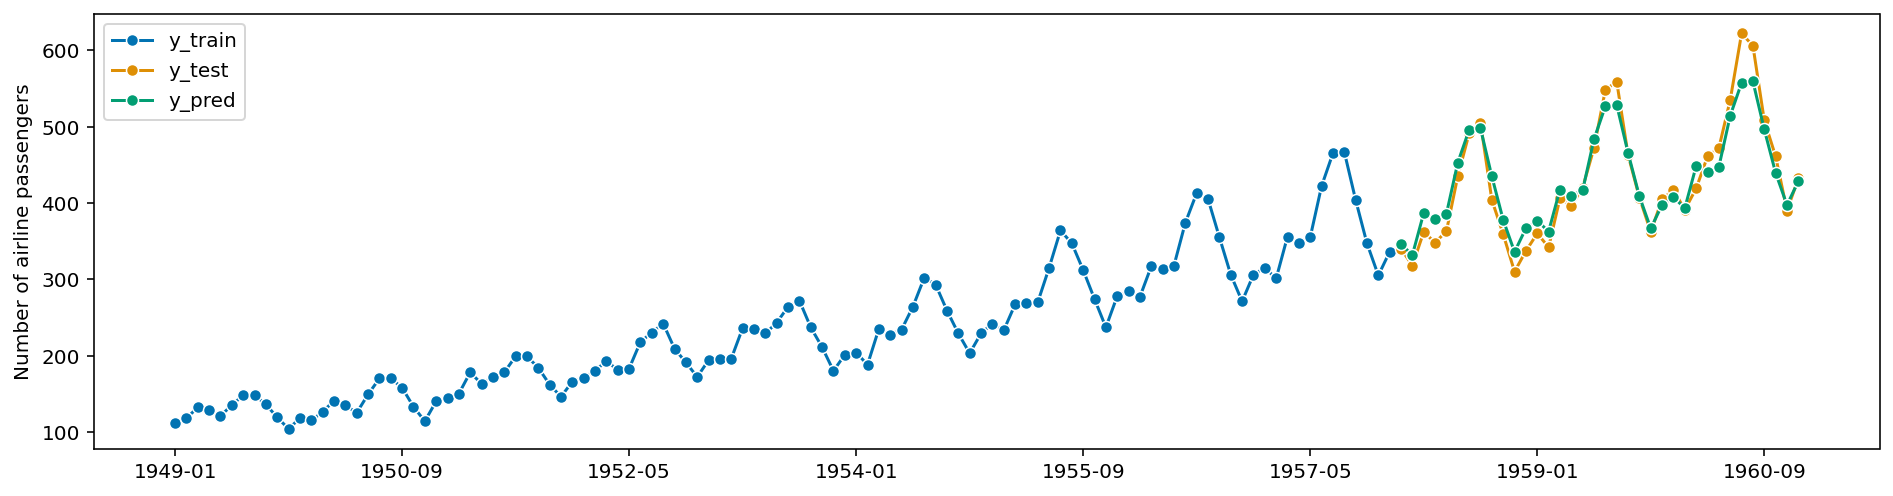

In [50]:
# создаем экземпляр класса StatsForecastAutoARIMA, 
# в котором реализована модель StatsForecastAutoARIMA
forecaster = StatsForecastAutoARIMA(sp=12)
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Классы BATS и TBATS

In [51]:
# импортируем класс BATS
from sktime.forecasting.bats import BATS

0.09310333533269292

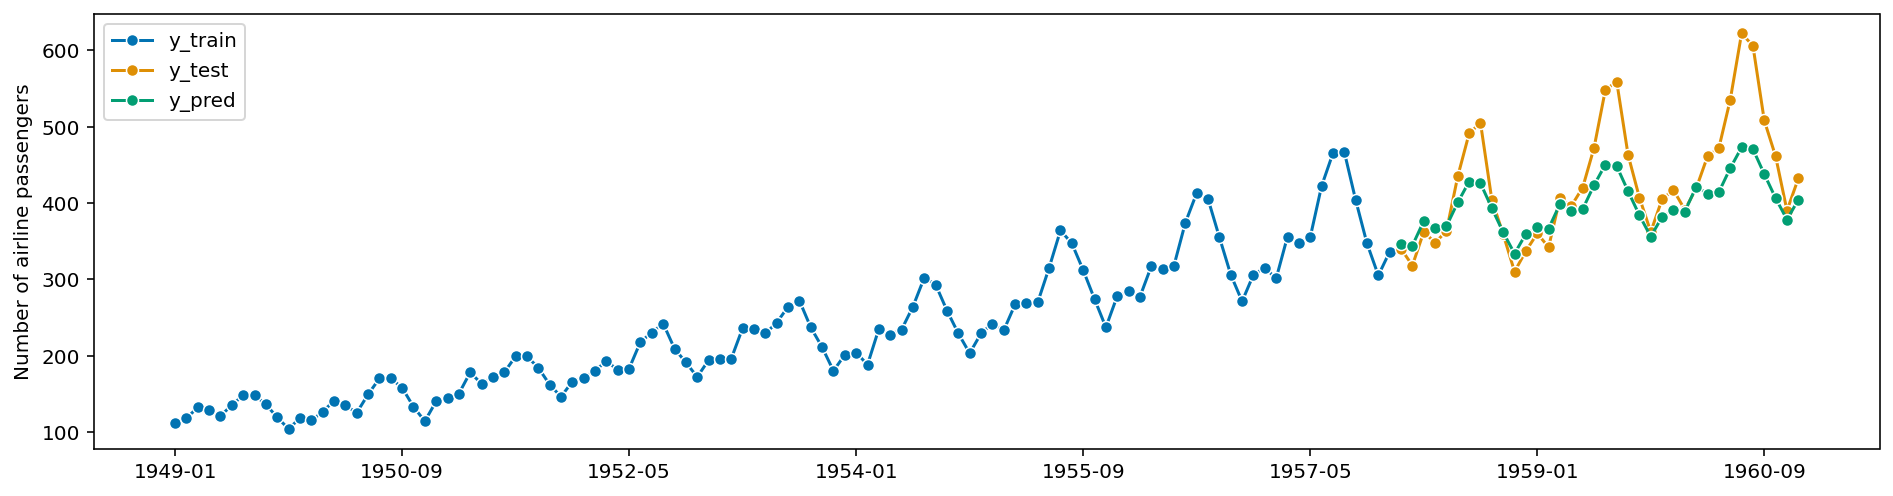

In [52]:
# создаем экземпляр класса BATS
forecaster = BATS(sp=12, use_trend=True, use_box_cox=False)
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

In [53]:
# импортируем класс TBATS
from sktime.forecasting.tbats import TBATS

0.09071779989124468

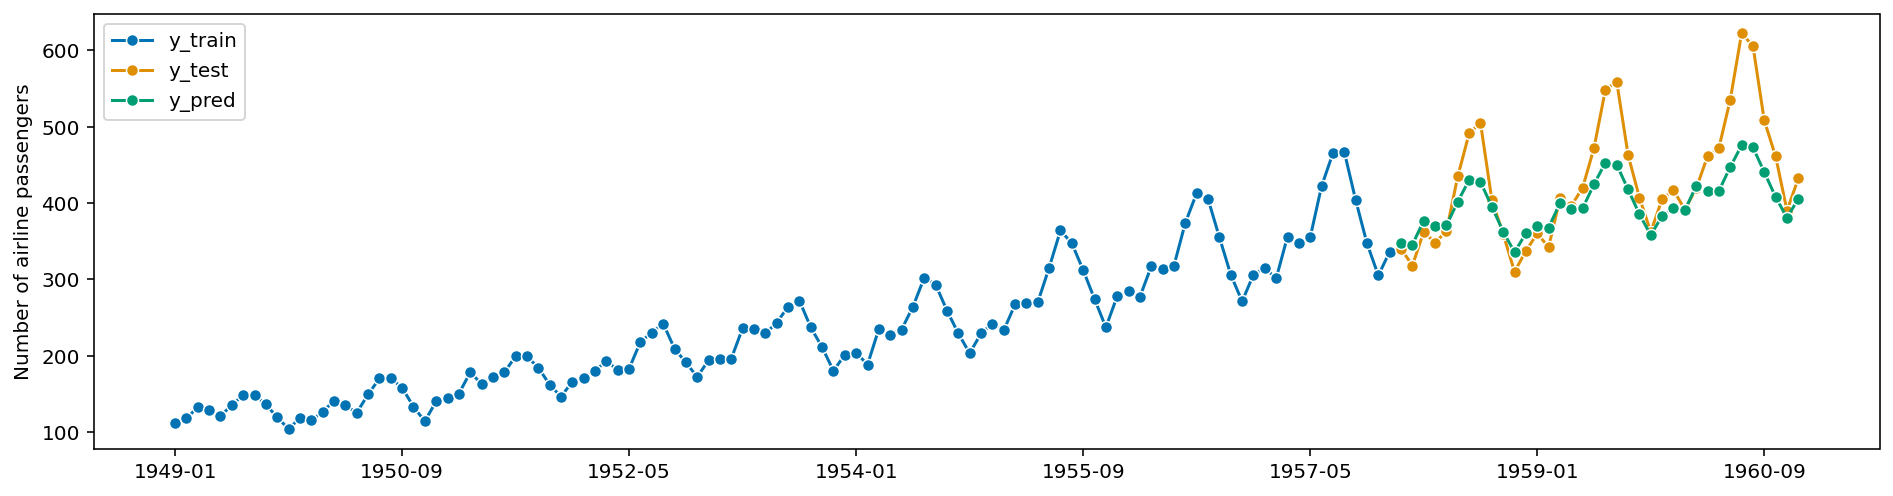

In [54]:
# создаем экземпляр класса TBATS
forecaster = TBATS(sp=12, use_trend=True, use_box_cox=False)
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Класс Prophet

In [55]:
# импортируем класс Prophet
from sktime.forecasting.fbprophet import Prophet

In [56]:
# создаем копию временного ряда
z = y.copy()
# преобразовываем индекс в pd.DatetimeIndex
z = z.to_timestamp(freq='M')
# разбиваем выборку на обучающую и тестовую с учетом 
# временной структуры, нам нужна только обучающая, 
# в нее не попадают последние 36 точек 
# (последние 3 года)
z_train, _ = temporal_train_test_split(z, test_size=36)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3fpjqkql/zh4sq5kd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3fpjqkql/t_8znzd3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3059', 'data', 'file=/tmp/tmp3fpjqkql/zh4sq5kd.json', 'init=/tmp/tmp3fpjqkql/t_8znzd3.json', 'output', 'file=/tmp/tmp3fpjqkql/prophet_modelgksnt6ea/prophet_model-20230110120227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


0.06607309940655243

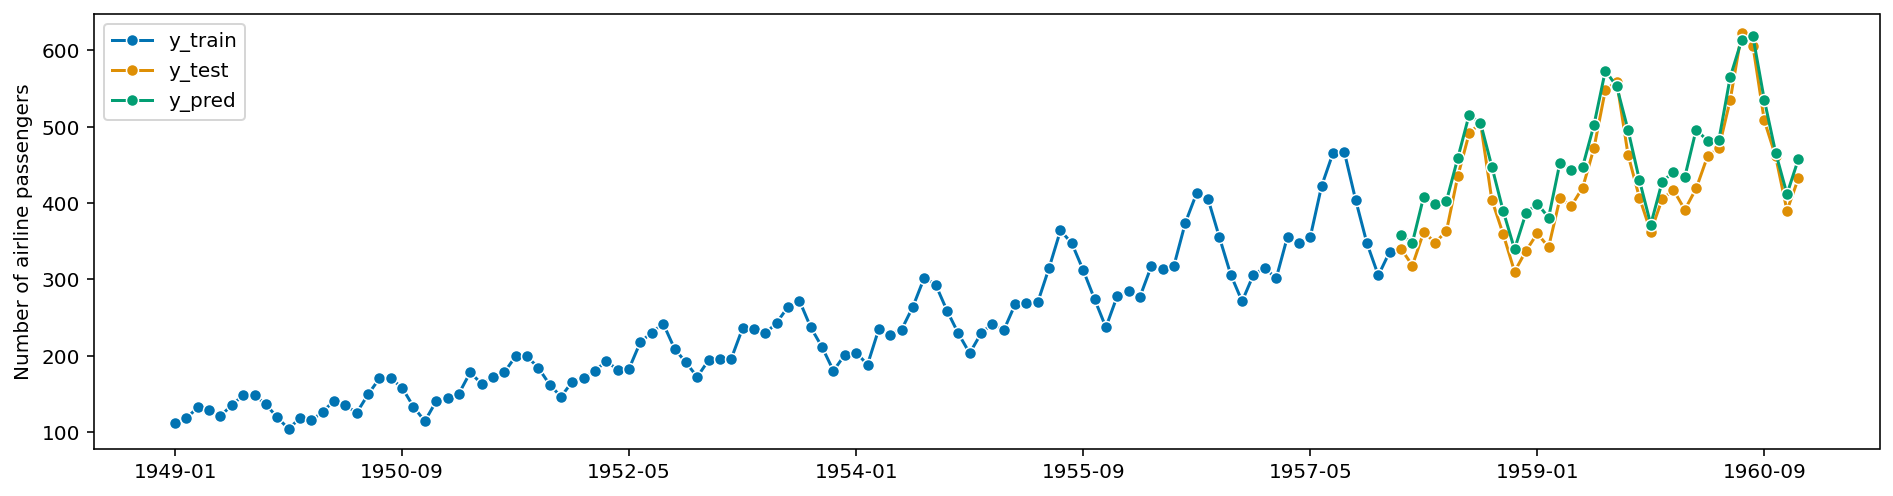

In [57]:
# создаем экземпляр класса Prophet
forecaster = Prophet(
    # задаем тип сезонности
    seasonality_mode='multiplicative',
    # задаем количество точек изменения тренда
    n_changepoints=int(len(y_train) / 12),
    # задаем календарь праздников, отмечаемых в данной стране
    add_country_holidays={'country_name': 'Germany'},
    # задаем факт наличия/отсутствия годовой сезонности
    yearly_seasonality=True,
    # задаем факт наличия/отсутствия недельной сезонности
    weekly_seasonality=False,
    # задаем факт наличия/отсутствия дневной сезонности
    daily_seasonality=False
)
# обучаем модель
forecaster.fit(z_train)
# получаем прогнозы, передав относительный горизонт, при этом
# в качестве отсечки - cutoff указываем последнюю временную
# точку обучающей выборки
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
# получаем индексы
y_pred.index = y_test.index
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

##  Прогнозирование нескольких временных рядов

In [58]:
# импортируем класс ColumnEnsembleForecaster, который прогнозирует
# каждый ряд с помощью отдельной модели
from sktime.forecasting.compose import ColumnEnsembleForecaster

# импортируем набор с несколькими рядами
from sktime.datasets import load_longley

# формируем массив меток, каждый столбец - это отдельный ряд 
# (здесь у нас 5 рядов)
_, y = load_longley()
# удаляем три ряда, оставив два
y = y.drop(columns=['UNEMP', 'ARMED', 'POP'])
y

,GNPDEFL,GNP
Period,,
1947,83.0,234289.0
1948,88.5,259426.0
1949,88.2,258054.0
1950,89.5,284599.0
1951,96.2,328975.0
1952,98.1,346999.0
1953,99.0,365385.0
1954,100.0,363112.0
1955,101.2,397469.0


In [59]:
# задаем список трехэлементных кортежей,
# первый элемент кортежа - название модели,
# второй элемент кортежа - экземпляр 
# соответствующего класса, в котором
# реализована модель, 
# третий элемент кортежа - индекс ряда
forecasters = [
    ('naive', NaiveForecaster(), 0),
    ('ses', ExponentialSmoothing(trend='add'), 1),
]
# задаем пул прогнозных моделей
forecaster = ColumnEnsembleForecaster(forecasters=forecasters)
# обучаем пул прогнозных моделей, задав горизонт
forecaster.fit(y, fh=[1, 2, 3])
# смотрим прогнозы
y_pred = forecaster.predict()
y_pred

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,GNPDEFL,GNP
1963,116.9,563821.430621
1964,116.9,584524.411275
1965,116.9,605227.391930


## Продвинутое моделирование

### Построение композитной модели - комбинации модели редукции и прогнозной модели-регрессора

Для выполнения редукции нам понадобится функция `make_reduction()`. В эту функцию нужно передать прогнозную модель-регрессор, длину окна и стратегию многошагового прогнозирования (она определяет модель редукции, в sktime реализованы четыре стратегии многошагового прогнозирования – четыре модели редукции).

In [60]:
# импортируем функцию make_reduction(), выполняющую редукцию
from sktime.forecasting.compose import make_reduction

0.1582308062892389

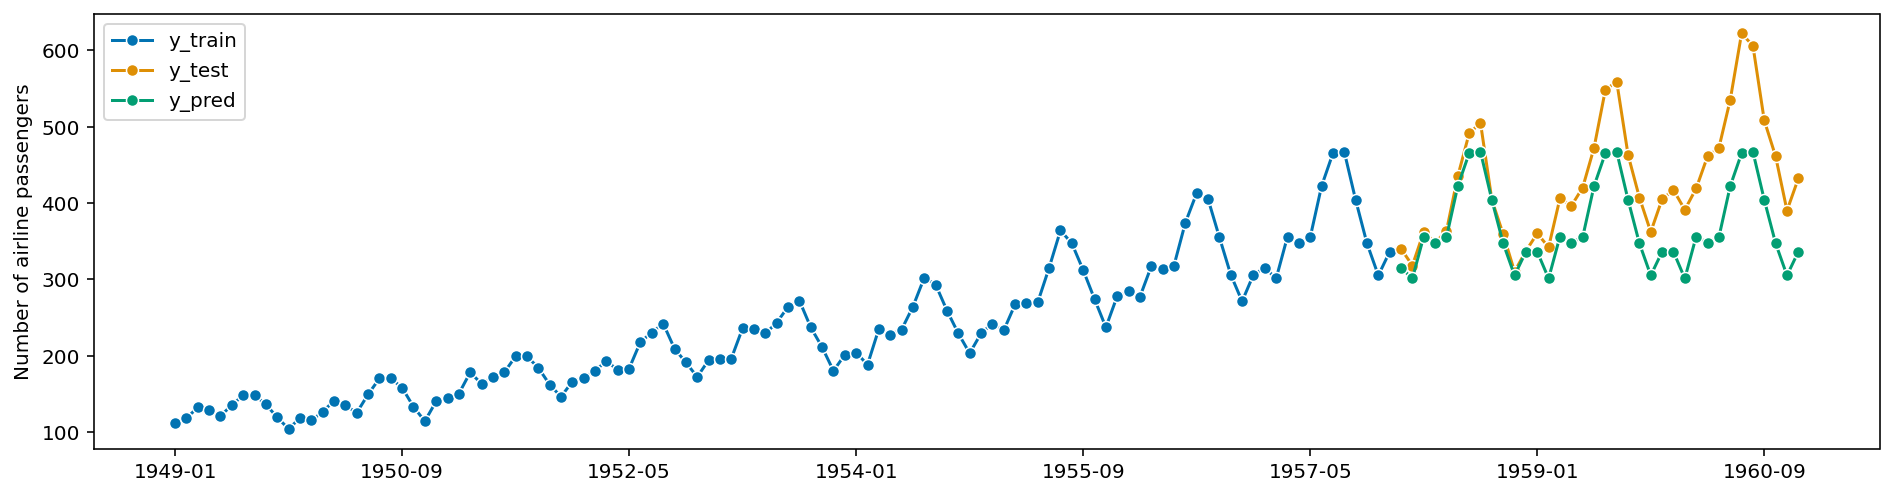

In [61]:
# импортируем класс KNeighborsRegressor, в котором
# реализована модель ближайших соседей
from sklearn.neighbors import KNeighborsRegressor

# создаем экземпляр класса KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=1)
# создаем композитную прогнозную модель - комбинацию модели
# редукции и конечной прогнозной модели-регрессора
forecaster = make_reduction(regressor, window_length=15, 
                            strategy='recursive')
# обучаем композитную прогнозную модель
forecaster.fit(y_train)
# задаем абсолютный горизонт прогнозирования
fh = ForecastingHorizon(y_test.index, is_relative=False)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Настройка гиперпараметров модели редукции и прогнозной модели-регрессора с помощью класса ForecastingGridSearchCV

С помощью класса `ForecastingGridSearchCV` мы можем настраивать гиперпараметры модели редукции и прогнозной модели-регрессора. Сейчас с его помощью мы попробуем настроить длину окна для модели редукции и количество деревьев для модели случайного леса – прогнозной модели-регрессора. Для валидации используем перекрестную проверку скользящим окном.

In [62]:
# импортируем класс ForecastingGridSearchCV для подбора гиперпараметров
from sktime.forecasting.model_selection import ForecastingGridSearchCV
# импортируем класс RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

In [63]:
# создаем регрессор
regressor = RandomForestRegressor(n_estimators=50, random_state=42)

# создаем композитную прогнозную модель - комбинацию модели
# редукции и конечной прогнозной модели-регрессора
forecaster = make_reduction(regressor, window_length=15, 
                            strategy='recursive')

# задаем сетку гиперпараметров
param_grid = {'window_length': [7, 12, 15], 
              'estimator__n_estimators': [50, 100, 150]}

# задаем перекрестную проверку скользящим окном
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), 
                           window_length=20)

# мы ищем оптимальные значения гиперпараметров модели редукции и
# модели-регрессора, которые дадут наименьшее усредненное значение
# sMAPE по результатам проверки скользящим окном
gscv = ForecastingGridSearchCV(forecaster, strategy='refit', cv=cv, 
                               param_grid=param_grid, scoring=mape)
gscv.fit(y_train)

# получаем прогнозы
y_pred = gscv.predict(fh)

In [64]:
# смотрим наилучшие гиперпараметры
gscv.best_params_

{'estimator__n_estimators': 50, 'window_length': 12}

In [65]:
# печатаем результаты поиска
pd.set_option('display.max_colwidth', 150)
pd.DataFrame(gscv.cv_results_)

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.107401,0.064051,0.009026,"{'estimator__n_estimators': 50, 'window_length': 7}",6.0
1,0.099932,0.063660,0.009455,"{'estimator__n_estimators': 50, 'window_length': 12}",1.0
2,0.111511,0.061256,0.009678,"{'estimator__n_estimators': 50, 'window_length': 15}",7.0
3,0.103211,0.115413,0.012930,"{'estimator__n_estimators': 100, 'window_length': 7}",5.0
4,0.100509,0.118545,0.012713,"{'estimator__n_estimators': 100, 'window_length': 12}",2.0
5,0.117204,0.116325,0.012220,"{'estimator__n_estimators': 100, 'window_length': 15}",9.0
6,0.103116,0.170033,0.015387,"{'estimator__n_estimators': 150, 'window_length': 7}",4.0
7,0.101300,0.168818,0.015600,"{'estimator__n_estimators': 150, 'window_length': 12}",3.0
8,0.115803,0.163937,0.016022,"{'estimator__n_estimators': 150, 'window_length': 15}",8.0


0.1244477367642092

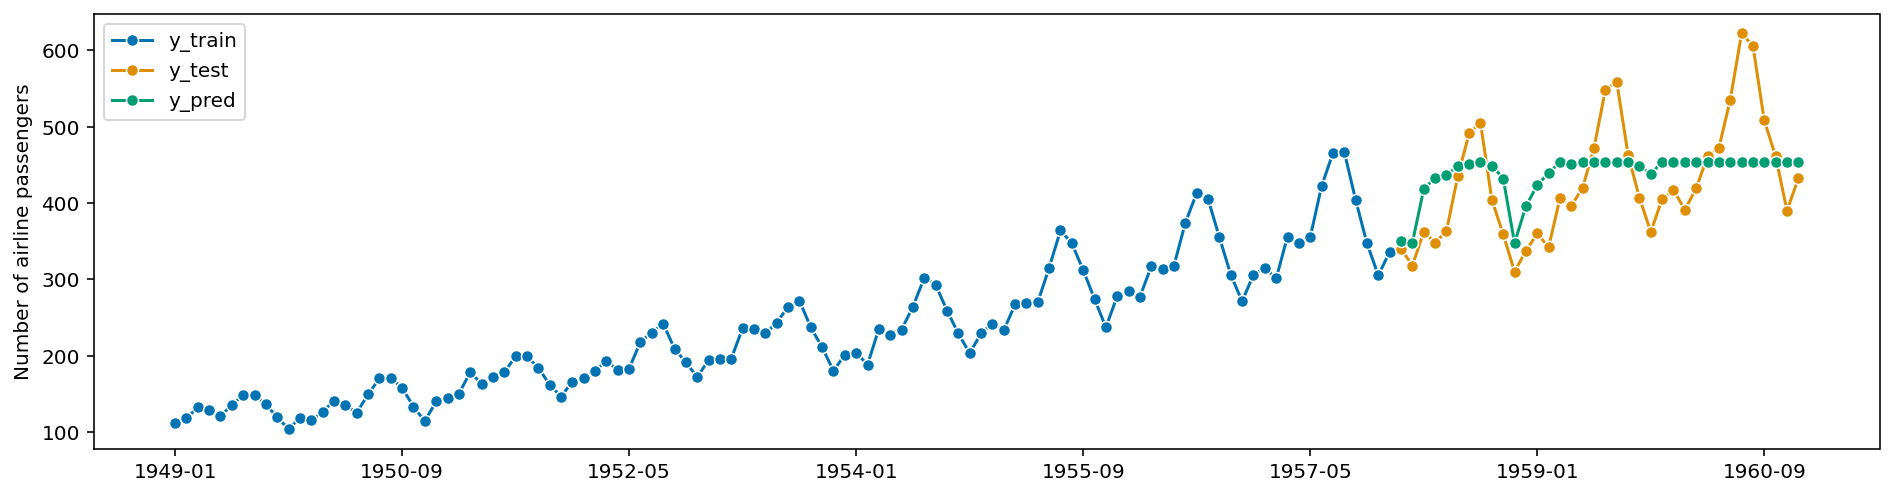

In [66]:
# визуализируем прогнозы
plot_series(y_train, y_test, 
            y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Удаление тренда и сезонности в данных с помощью классов Detrender и Deseasonalizer

In [67]:
# импортируем класс PolynomialTrendForecaster, 
# предсказывающий тренд
from sktime.forecasting.trend import PolynomialTrendForecaster
# импортируем классы Deseasonalizer и Detrender 
# для вычитания тренда и сезонности
from sktime.transformations.series.detrend import (Deseasonalizer, 
                                                   Detrender)

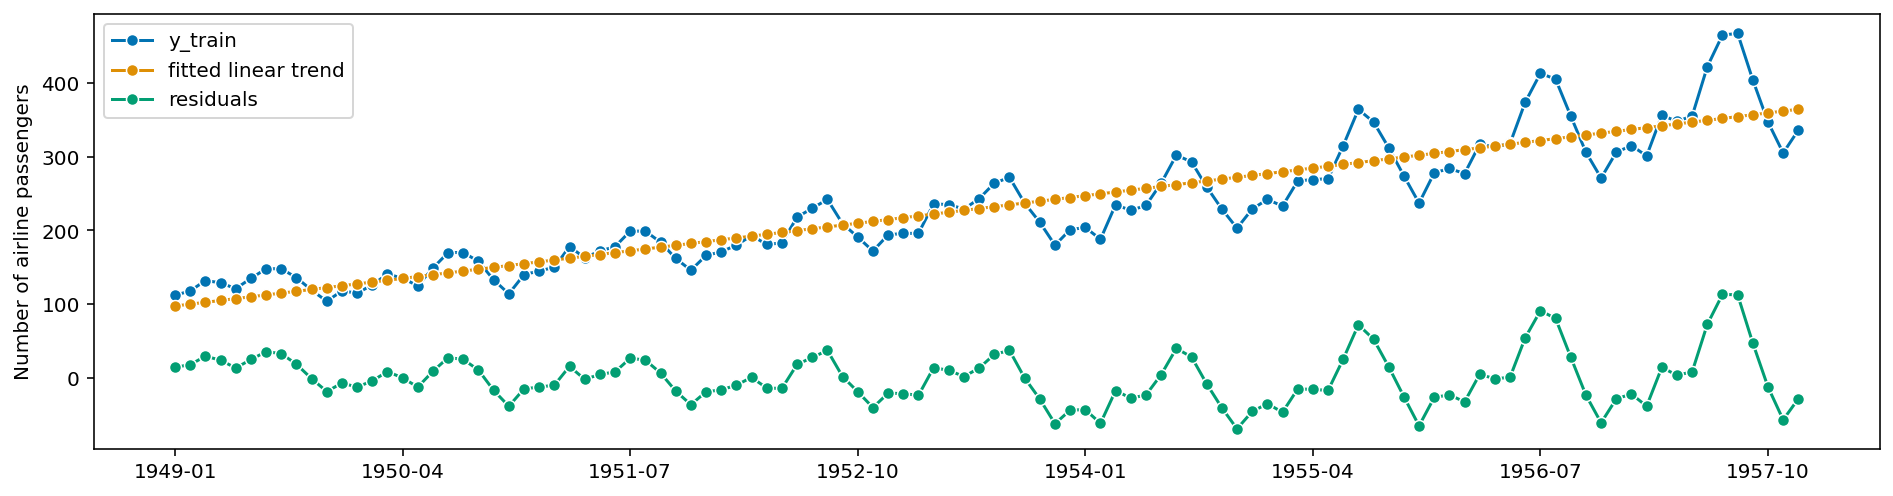

In [68]:
# создаем модель, предсказывающую тренд
forecaster = PolynomialTrendForecaster(degree=1)
# создаем модель-детрендер
transformer = Detrender(forecaster=forecaster)
# прогнозируем и удаляем тренд, в итоге получаем остатки
yt = transformer.fit_transform(y_train)
# создаем модель, предсказывающую тренд
forecaster = PolynomialTrendForecaster(degree=1)
# задаем горизонт прогнозирования
fh_ins = -np.arange(len(y_train))
# получаем прогнозы - предсказанный тренд
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)
# визуализируем фактические значения, 
# спрогнозированный тренд и остатки
plot_series(y_train, y_pred, yt, 
            labels=['y_train', 'fitted linear trend', 'residuals']);

### Конвейеризация с помощью класса TransformedTargetForecaster

In [69]:
# импортируем класс TransformedTargetForecaster, 
# позволяющий создавать конвейеры
from sktime.forecasting.compose import TransformedTargetForecaster

0.05712480897928843

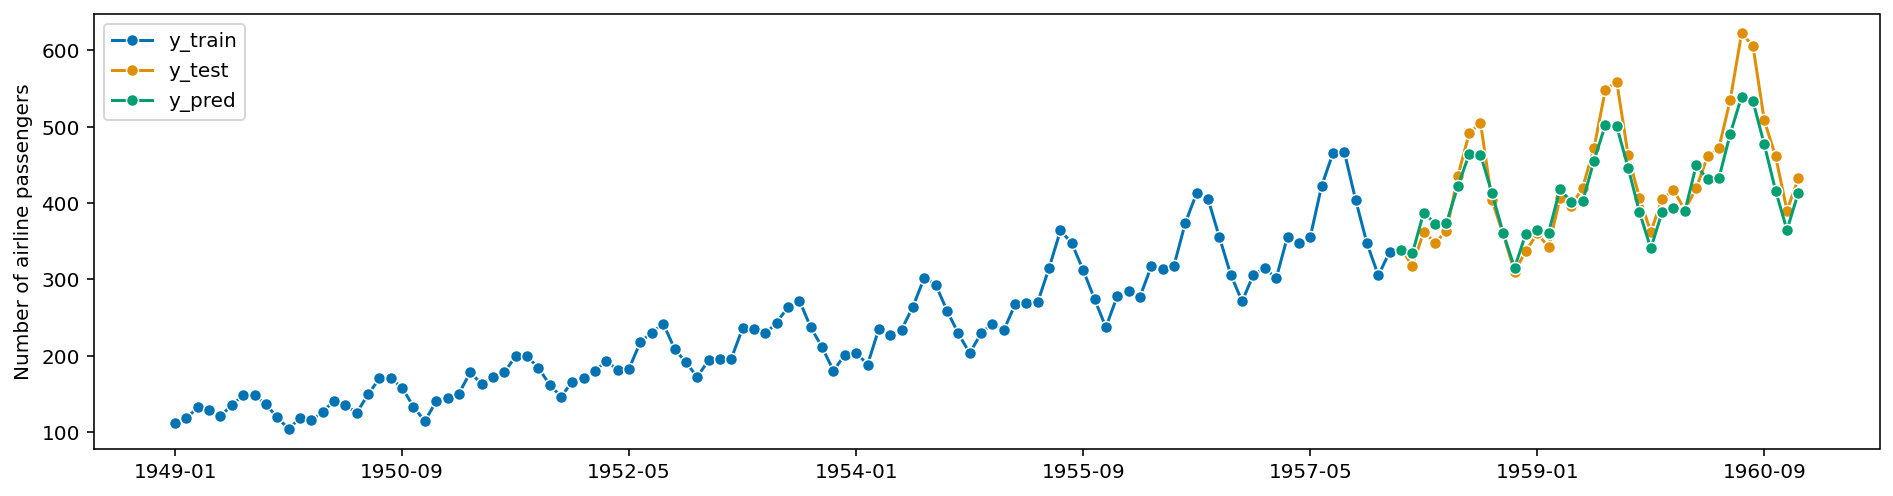

In [70]:
# создаем экземпляр класса TransformedTargetForecaster
forecaster = TransformedTargetForecaster(
    [('deseasonalize', Deseasonalizer(model='multiplicative', sp=12)),
     ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
     ('forecast', make_reduction(regressor, scitype='tabular-regressor', 
                                 window_length=15, strategy='recursive'))]
)
# обучаем модель, по сути удаляем тренд, сезонность 
# и обучаем композитную прогнозную модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Автоматический выбор модели с помощью классов ForecastingGridSearchCV и MultiplexForecaster

Класс `MultiplexForecaster` в связке с классом `ForecastingGridSearchCV` позволяет автоматически отобрать наилучшую прогнозную модель. Сам по себе `MultiplexForecaster` принимает на вход разные прогнозные модели sktime, указанные с помощью параметра `forecasters`, а с помощью ключа `selected_forecaster` словаря - сетки гиперпараметров он выбирает, какая прогнозная модель будет обучена при вызове `.fit()`. Настоящее преимущество класса `MultiplexForecaster` достигается, когда класс `MultiplexForecaster` используется вместе с классом `ForecastingGridSearchCV`. Параметр `selected_forecaster` становится гиперпараметром класса `MultiplexForecaster`. Таким образом, `ForecastingGridSearchCV` позволяет `MultiplexForecaster` переключаться между разными прогнозными моделями, чтобы найти модель, дающую наилучшее качество для имеющихся обучающих данных.

In [71]:
# импортируем класс MultiplexForecaster, отвечающий
# за автоматический отбор моделей
from sktime.forecasting.compose import MultiplexForecaster

In [72]:
# создаем экземпляр класса MultiplexForecaster
forecaster = MultiplexForecaster(
    forecasters=[
        ('arima', ARIMA(order=(1, 1, 0), 
                        seasonal_order=(0, 1, 0, 12), 
                        suppress_warnings=True)),
        ('ets', ExponentialSmoothing(trend='add', sp=12))]
)

# задаем стратегию перекрестной проверки
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5), 
                           window_length=30)
# задаем сетку гиперпараметров
forecaster_param_grid = {'selected_forecaster': ['arima', 'ets']}
# задаем модель поиска наилучших гиперпараметров
gscv = ForecastingGridSearchCV(forecaster, 
                               cv=cv, 
                               param_grid=forecaster_param_grid)

# обучаем модель
gscv.fit(y_train)
# получаем прогнозы
y_pred = gscv.predict(fh)

In [73]:
# печатаем результаты поиска
pd.DataFrame(gscv.cv_results_)

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.029092,0.053596,0.011210,{'selected_forecaster': 'arima'},1.0
1,0.094524,0.022744,0.005515,{'selected_forecaster': 'ets'},2.0


In [74]:
# смотрим наилучшие гиперпараметры
gscv.best_params_

{'selected_forecaster': 'arima'}

0.04166639016608004

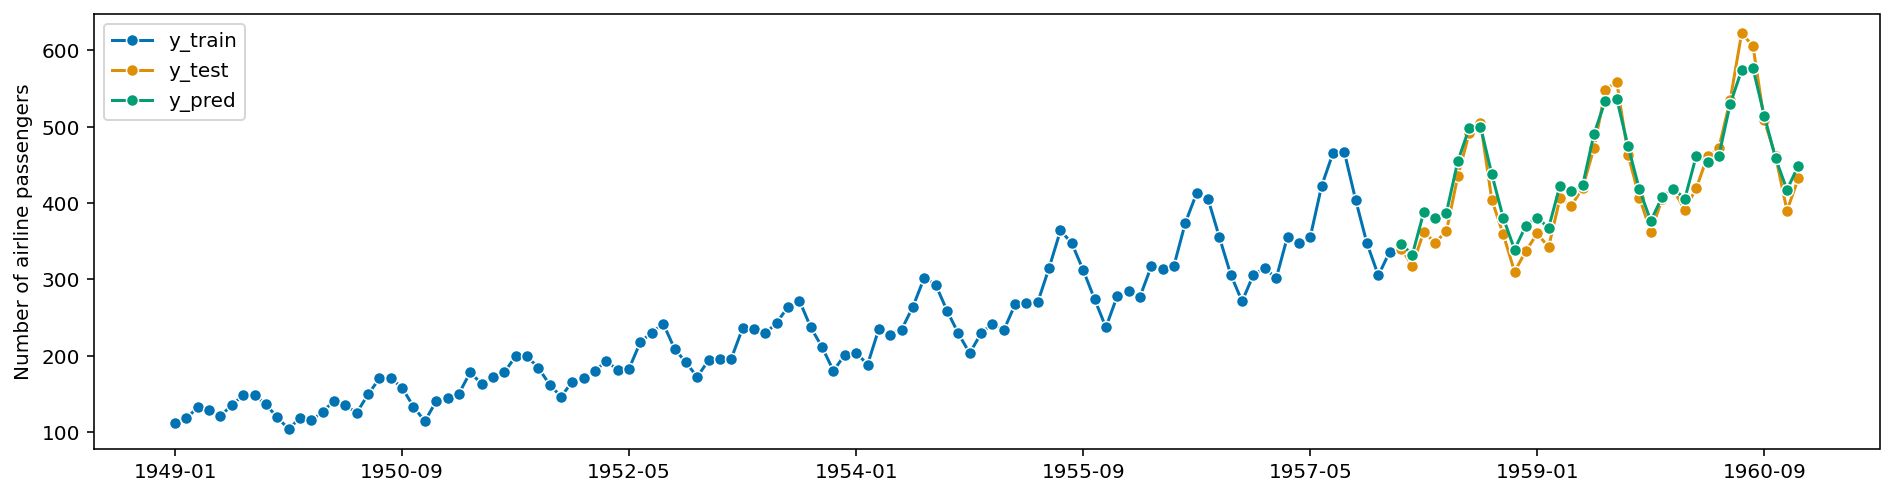

In [75]:
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Простое ансамблирование прогнозных моделей с помощью класса EnsembleForecaster

С помощью класса `EnsembleForecaster` можно выполнить простое ансамблирование прогнозных моделей. C помощью параметра `forecasters` задаем список двухэлементных кортежей, первый элемент кортежа – название этапа, второй элемент кортежа – экземпляр класса, в котором реализована прогнозная модель sktime. С помощью параметра `aggfunc` задаем способ агрегирования прогнозов моделей, доступны значения `'mean'` (по умолчанию), `'median'`, `'min'` и `'max'`.

In [76]:
# импортируем класс EnsembleForecaster, позволяющий выполнять
# простое ансамблирование прогнозных моделей
from sktime.forecasting.compose import EnsembleForecaster

0.03944363133431644

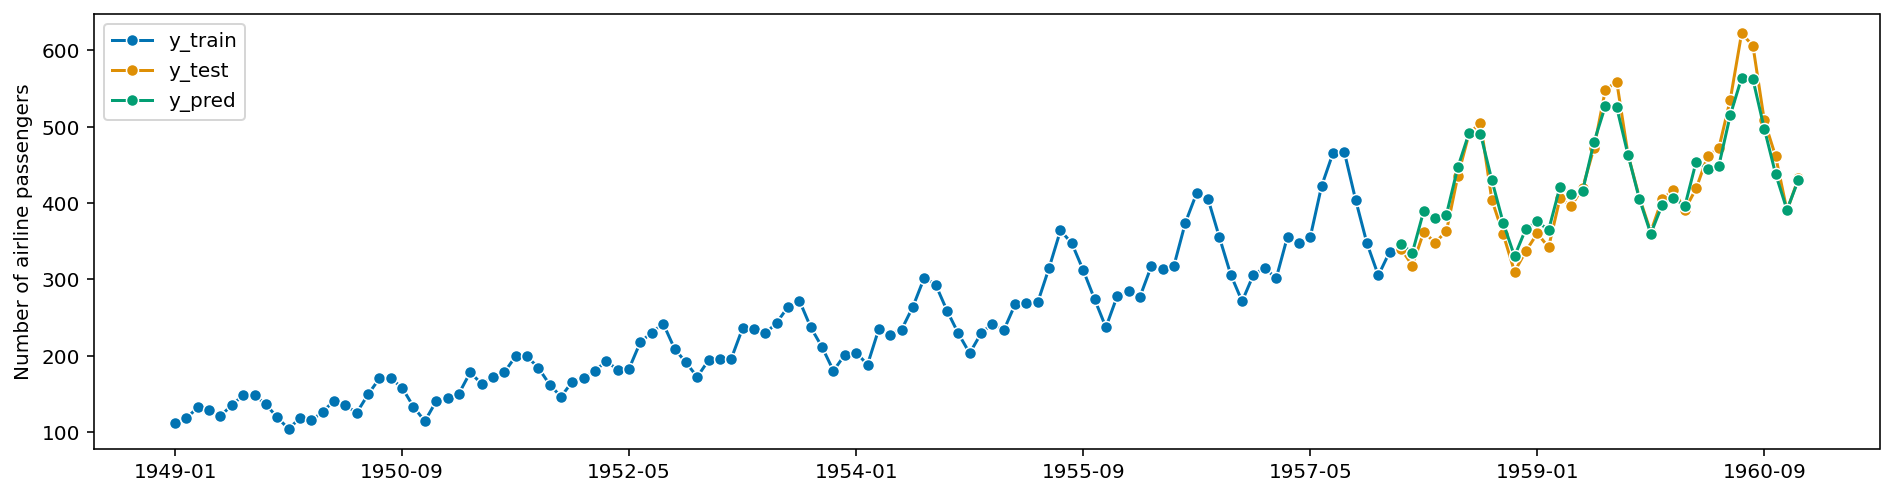

In [77]:
# создаем отдельные модели
holt = ExponentialSmoothing(trend='add', seasonal='mul', sp=12)
arima = ARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 0, 12), 
              suppress_warnings=True)
# создаем метамодель
forecaster = EnsembleForecaster(forecasters=[('holt', holt), ('arima', arima)],
                                aggfunc='mean')
# обучаем модель
forecaster.fit(y_train)
# получаем прогнозы
y_pred = forecaster.predict(fh)
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
# вычисляем sMAPE
mean_absolute_percentage_error(y_pred, y_test)

### Автоматический отбор трансформеров внутри конвейера и настройка гиперпараметров прогнозной модели с помощью классов OptionalPassthrough и TransformedTargetForecaster

Библиотека sktime выполняет автоматический отбор компонентов конвейера внутри него самого с помощью класса `OptionalPassthrough`. По сути класс `OptionalPassthrough` – это метатрансформер, который позволяет нам выяснить, нужно ли внутри конвейера применять трансформер к данным или нет. Например, мы хотим выяснить, даст ли преимущество для нашей прогнозной модели стандартизация – класс `StandardScaler` из sklearn или нет, и передаем его классу `OptionalPassthrough`. Для этого указываем название трансформера (берем первый элемент двухэлементного кортежа из списка, заданного с помощью параметра `steps` класса `TransformedTargetForecaster`), добавляем символ двойного нижнего подчеркивания __ и добавляем ключевое слово `passthrough`, например, 
```
'scaler__passthrough': [True, False]
```
В следующем примере мы попробуем выполнить/не выполнить удаление сезонности, выполнить/не выполнить стандартизацию (с центрированием/без центрирования) в сочетании с тремя разными стратегиями прогнозирования для модели наивного прогноза внутри конвейера и таким образом попробуем 2×2×2×3=24 комбинации.

In [78]:
# импортируем класс OptionalPassthrough, 
# выступающий в качестве метатрансформера
from sktime.transformations.compose import OptionalPassthrough
# импортируем классы TabularToSeriesAdaptor и StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler

In [79]:
# создаем конвейер из трансформеров и прогнозной модели
pipe = TransformedTargetForecaster(
    steps=[
        ('deseasonalizer', OptionalPassthrough(Deseasonalizer())),
        ('scaler', OptionalPassthrough(
            TabularToSeriesAdaptor(StandardScaler()))),
        ('forecaster', NaiveForecaster()),
    ]
)

# задаем стратегию перекрестной проверки
cv = SlidingWindowSplitter(initial_window=60, 
                           window_length=24, 
                           start_with_window=True, 
                           step_length=24)

# задаем сетку гиперпараметров
param_grid = {
    'deseasonalizer__passthrough': [True, False],
    'scaler__transformer__transformer__with_mean': [True, False],
    'scaler__passthrough': [True, False],
    'forecaster__strategy': ['drift', 'mean', 'last'],
}

# выполняем поиск лучшей комбинации
gscv = ForecastingGridSearchCV(forecaster=pipe, 
                               param_grid=param_grid, 
                               cv=cv, 
                               n_jobs=-1)
gscv.fit(y_train)

# получаем прогнозы
y_pred = gscv.predict(fh)

In [80]:
# печатаем результаты поиска
pd.DataFrame(gscv.cv_results_)

,mean_test_MeanAbsolutePercentageError,mean_fit_time,mean_pred_time,params,rank_test_MeanAbsolutePercentageError
0,0.008555,0.058528,0.023118,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'drift', 'scaler__passthrough': True, 'scaler__transformer__transformer__with_mean':...",4.5
1,0.008555,0.059073,0.020106,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'drift', 'scaler__passthrough': True, 'scaler__transformer__transformer__with_mean':...",4.5
2,0.008555,0.074089,0.025475,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'drift', 'scaler__passthrough': False, 'scaler__transformer__transformer__with_mean'...",4.5
3,0.008555,0.065636,0.020893,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'drift', 'scaler__passthrough': False, 'scaler__transformer__transformer__with_mean'...",4.5
4,0.118853,0.067946,0.021450,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'mean', 'scaler__passthrough': True, 'scaler__transformer__transformer__with_mean': ...",21.5
5,0.118853,0.062831,0.020587,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'mean', 'scaler__passthrough': True, 'scaler__transformer__transformer__with_mean': ...",21.5
6,0.118853,0.067732,0.018474,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'mean', 'scaler__passthrough': False, 'scaler__transformer__transformer__with_mean':...",21.5
7,0.118853,0.072080,0.021633,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'mean', 'scaler__passthrough': False, 'scaler__transformer__transformer__with_mean':...",17.5
8,0.017916,0.056360,0.017982,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'last', 'scaler__passthrough': True, 'scaler__transformer__transformer__with_mean': ...",12.5
9,0.017916,0.058205,0.018026,"{'deseasonalizer__passthrough': True, 'forecaster__strategy': 'last', 'scaler__passthrough': True, 'scaler__transformer__transformer__with_mean': ...",12.5


0.1299046419013891

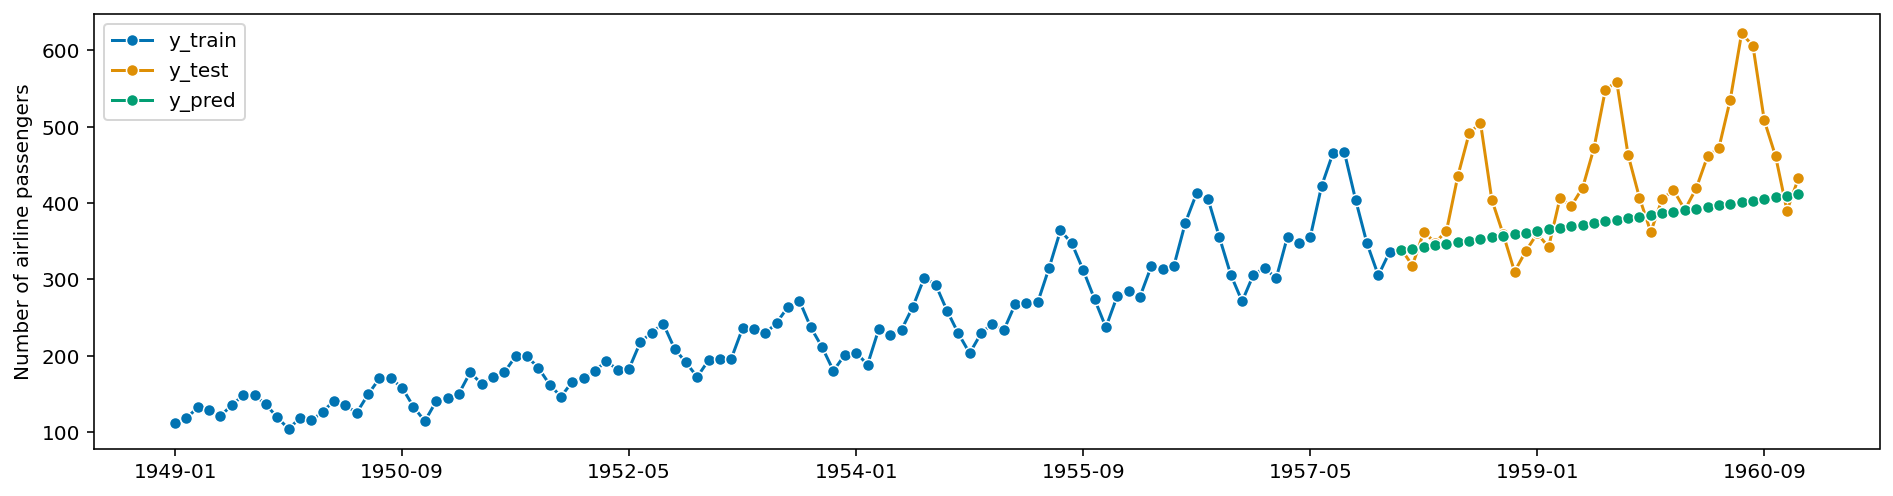

In [81]:
# визуализируем прогнозы
plot_series(y_train, y_test, y_pred, 
            labels=['y_train', 'y_test', 'y_pred'])
# получаем оценку качества
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

## Прогнозирование иерархических временных рядов

sktime предоставляет унифицированный интерфейс для прогнозирования иерархических рядов.

Все модели sktime могут применяться к панельным и иерархическим данным, которые должны быть представлены в определенных входных форматах. Модели, которые изначально не могут быть применены к иерархическим и панельным данным, будут обучаться отдельно на одном ряде.

Рекомендуемый (но не единственный) формат для передачи панельных и иерархических данных — это `pandas.DataFrame` со строками `MultiIndex`. Последний уровень `MultiIndex` должен быть в формате индекса времени, совместимом с sktime, остальные уровни являются узлами панели или иерархии.

In [82]:
# загружаем иерархический временной ряд
from sktime.utils._testing.hierarchical import _bottom_hier_datagen

y = _bottom_hier_datagen(no_levels=2)
y

passengers
l2_agg    l1_agg    timepoints             
l2_node01 l1_node02 1949-01     1571.550000
                    1949-02     1654.770000
                    1949-03     1848.950000
                    1949-04     1807.340000
                    1949-05     1696.380000
...                                     ...
l2_node02 l1_node06 1960-08     2255.355536
                    1960-09     1891.588497
                    1960-10     1717.122382
                    1960-11     1453.557358
                    1960-12     1609.470615

[864 rows x 1 columns]

In [83]:
# задаем горизонт
fh = [1, 2, 3]
# обучаем модель
forecaster = ARIMA()
forecaster.fit(y, fh=fh)
# получаем прогнозы
forecaster.predict()

passengers
l2_agg    l1_agg    timepoints              
l2_node01 l1_node02 1961-01      5934.291865
                    1961-02      5861.313917
                    1961-03      5790.921208
          l1_node04 1961-01      7670.379053
                    1961-02      7576.031943
                    1961-03      7485.026003
l2_node02 l1_node01 1961-01       426.544850
                    1961-02       421.282983
                    1961-03       416.207550
          l1_node03 1961-01      1673.694946
                    1961-02      1653.166698
                    1961-03      1633.365627
          l1_node05 1961-01     13627.398837
                    1961-02     13341.040728
                    1961-03     13070.973038
          l1_node06 1961-01      1589.221298
                    1961-02      1569.689243
                    1961-03      1550.849044

Как и в случае с прогнозированием нескольких рядов, модели, которые изначально не умеют работать с иерархическими рядами, обучаются для каждого ряда отдельно. Доступ к моделям, обученным в формате "одна модель - один ряд", можно получить с помощью атрибута `forecasters_`, реультат будет представлять собой `pandas.DataFrame`. В нем модель для данного ряда помещается в строку вместе с индексом ряда, для которого она делает прогнозы.

In [84]:
# список моделей
forecaster.forecasters_

forecasters
l2_agg    l1_agg               
l2_node01 l1_node02     ARIMA()
          l1_node04     ARIMA()
l2_node02 l1_node01     ARIMA()
          l1_node03     ARIMA()
          l1_node05     ARIMA()
          l1_node06     ARIMA()

## Получение справочной информации о прогнозных моделях

С помощью функции `all_estimators()` и ее параметра `return_tags` можно получить подробную информацию о моделях:

- `requires-fh-in-fit` - логический тип. Требуется ли прогнозной модели горизонт прогнозирования `fh` уже в методе `.fit()` (`True`) или его можно передать позже в методе `.predict()` (`False`).

- `scitype:y` - строковый тип. Работает ли модель с одним рядом (`'univariate'`), строго с несколькими рядами (`'multivariate'`) или может работать с любым количеством рядов (`'both'`).

- `capability:pred_int` - логический тип. Может ли модель выдавать вероятностные прогнозы с помощью параметра `predict_interval`.

- `ignores-exogeneous-X` - логический тип. Может ли модель работать с экзогенными переменными X (`False`) или нет (`True`).

- `handles-missing-data` - логический тип. Может ли модель работать с пропусками в X или y.

Теги прогнозной модели можно посмотреть с помощью методов `.get_tags()` (выводит все теги) и `get_tag()` (выводит значение для одного тега).

In [85]:
# импортируем нужную нам функцию all_estimators()
from sktime.registry import all_estimators

# выводим общее описание моделей
all_estimators('forecaster', as_dataframe=True)

,name,estimator
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.AutoEnsembleForecaster'>
5,BATS,<class 'sktime.forecasting.bats.BATS'>
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.BaggingForecaster'>
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ensemble.ColumnEnsembleForecaster'>
8,ConformalIntervals,<class 'sktime.forecasting.conformal.ConformalIntervals'>
9,Croston,<class 'sktime.forecasting.croston.Croston'>


In [86]:
# посмотрим, какие модели работают с несколькими рядами
# и требуют передачи горизонта в метод .fit()
all_estimators(
    'forecaster', as_dataframe=True, 
    return_tags=['scitype:y', 'requires-fh-in-fit']
)

,name,estimator,scitype:y,requires-fh-in-fit
0,ARDL,<class 'sktime.forecasting.ardl.ARDL'>,univariate,False
1,ARIMA,<class 'sktime.forecasting.arima.ARIMA'>,univariate,False
2,AutoARIMA,<class 'sktime.forecasting.arima.AutoARIMA'>,univariate,False
3,AutoETS,<class 'sktime.forecasting.ets.AutoETS'>,univariate,False
4,AutoEnsembleForecaster,<class 'sktime.forecasting.compose._ensemble.AutoEnsembleForecaster'>,univariate,False
5,BATS,<class 'sktime.forecasting.bats.BATS'>,univariate,False
6,BaggingForecaster,<class 'sktime.forecasting.compose._bagging.BaggingForecaster'>,univariate,False
7,ColumnEnsembleForecaster,<class 'sktime.forecasting.compose._column_ensemble.ColumnEnsembleForecaster'>,both,False
8,ConformalIntervals,<class 'sktime.forecasting.conformal.ConformalIntervals'>,univariate,False
9,Croston,<class 'sktime.forecasting.croston.Croston'>,univariate,False


In [87]:
# выведем теги модели ARIMA
ARIMA().get_tags()

{'scitype:y': 'univariate',
 'ignores-exogeneous-X': False,
 'capability:pred_int': True,
 'handles-missing-data': True,
 'y_inner_mtype': 'pd.Series',
 'X_inner_mtype': 'pd.DataFrame',
 'requires-fh-in-fit': False,
 'X-y-must-have-same-index': True,
 'enforce_index_type': None,
 'fit_is_empty': False,
 'python_version': None,
 'python_dependencies': 'pmdarima'}